In [1]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from joblib import dump
import geohash2 as geohash
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from scipy.stats import zscore




In [2]:
# Load the dataset from csv file
df = pd.read_csv('AmazonDataSales.csv', low_memory=False)
#Drop columns with only 1 unique value: ship-country, currency, index
df.drop(['ship-country', 'currency', 'index'], axis=1, inplace=True)
#Null values
df.isnull().sum()
#Make all columns lowercase
df.columns = df.columns.str.lower()
#Make all content in 'ship-city' column lower case
df['ship-city'] = df['ship-city'].str.lower()

In [3]:
# Caluculate and display percentage null values in columns with null values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        null_percentage = df[col].isnull().sum() / len(df) * 100
        print(f"{col} has {null_percentage:.2f}% null values")

courier status has 5.33% null values
amount has 6.04% null values
ship-city has 0.03% null values
ship-state has 0.03% null values
ship-postal-code has 0.03% null values
promotion-ids has 38.11% null values
fulfilled-by has 69.55% null values
unnamed: 22 has 38.03% null values


In [4]:
#Explore number of unique values in each column
unique_values = df.nunique()
print(unique_values)

order id              120378
date                      91
status                    13
fulfilment                 2
sales channel              2
ship-service-level         2
style                   1377
sku                     7195
category                   9
size                      11
asin                    7190
courier status             3
qty                       10
amount                  1410
ship-city               7297
ship-state                69
ship-postal-code        9459
promotion-ids           5787
b2b                        2
fulfilled-by               1
unnamed: 22                1
dtype: int64


In [5]:
#Fill in missing fullfilled-by with 'unknowns-ship'
df['fulfilled-by'] = df['fulfilled-by'].fillna('unknowns-ship')
#Fill in missing Unnamed: 22 with 'unknown-boolean'
df['unnamed: 22'] = df['unnamed: 22'].fillna('unknown-boolean')
#Fill in missing promotion-ids with 'potential-id-unknown'
df['promotion-ids'] = df['promotion-ids'].fillna('potential-id-unknown')
#Fill in missing Courier Status with 'Unknown'
df['courier status'] = df['courier status'].fillna('Unknown')
#Fill in missing ship-state with 'unknown-state'
df['ship-state'] = df['ship-state'].fillna('unknown-state')
#Fill in missing ship-city with 'unknown-city'
df['ship-city'] = df['ship-city'].fillna('unknown-city')
#Fill in missing ship-postal-code with 'unknown-address'
df['ship-postal-code'] = df['ship-postal-code'].fillna('unknown-address')

In [6]:
## Might fill these in later instead of dropping rows
# Drop rows with empty 'Amount' values
df.dropna(subset=['amount'], inplace=True)

In [7]:
df['date'] = pd.to_datetime(df['date'], format='%m-%d-%y', errors='coerce')

In [8]:
#Make all content lower-case
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)

##### Correct 'state_name'

In [9]:
# show the unique values in 'state-name' column
df['ship-state'].unique()

array(['maharashtra', 'karnataka', 'puducherry', 'tamil nadu',
       'uttar pradesh', 'chandigarh', 'telangana', 'andhra pradesh',
       'rajasthan', 'delhi', 'haryana', 'assam', 'jharkhand',
       'chhattisgarh', 'odisha', 'kerala', 'madhya pradesh',
       'west bengal', 'nagaland', 'gujarat', 'uttarakhand', 'bihar',
       'jammu & kashmir', 'punjab', 'himachal pradesh',
       'arunachal pradesh', 'manipur', 'goa', 'meghalaya', 'tripura',
       'ladakh', 'dadra and nagar', 'sikkim', 'unknown-state',
       'andaman & nicobar ', 'rajshthan', 'nl', 'mizoram', 'new delhi',
       'punjab/mohali/zirakpur', 'rj', 'orissa', 'lakshadweep', 'pb',
       'ar', 'pondicherry', 'rajsthan'], dtype=object)

In [10]:
def correct_state_name(state_name):
    corrections = {
        'arunachal pradesh': 'arunachal pradesh',
        'bihar': 'bihar',
        'chandigarh': 'chandigarh',
        'delhi': 'delhi',
        'goa': 'goa',
        'gujarat': 'gujarat',
        'haryana': 'haryana',
        'himachal pradesh': 'himachal pradesh',
        'jammu & kashmir': 'jammu & kashmir',
        'jharkhand': 'jharkhand',
        'karnataka': 'karnataka',
        'kerala': 'kerala',
        'ladakh': 'ladakh',
        'lakshadweep': 'lakshadweep',
        'madhya pradesh': 'madhya pradesh',
        'maharashtra': 'maharashtra',
        'manipur': 'manipur',
        'meghalaya': 'meghalaya',
        'mizoram': 'mizoram',
        'nagaland': 'nagaland',
        'odisha': 'odisha',
        'puducherry': 'puducherry',
        'punjab': 'punjab',
        'rajasthan': 'rajasthan',
        'sikkim': 'sikkim',
        'tamil nadu': 'tamil nadu',
        'telangana': 'telangana',
        'tripura': 'tripura',
        'uttar pradesh': 'uttar pradesh',
        'uttarakhand': 'uttarakhand',
        'west bengal': 'west bengal',
        'nan': 'unknown',
        'rajshthan': 'rajasthan',
        'rajsthan': 'rajasthan',
        'rj' : 'rajasthan',
        'orissa': 'odisha',  # Orissa is the former name of odisha
        'new delhi': 'delhi',  # New delhi is part of delhi
        'pondicherry': 'puducherry',  # Pondicherry was renamed to puducherry
        'punjab/mohali/zirakpur': 'punjab',  # Specific cities in punjab
        'pb' : 'punjab'   
    }
    # The first state_name.lower() returns rows that were not corrected. Otherwise the new list is only the corrections.
    return corrections.get(state_name.lower(), state_name)

# Apply the corrections to the 'ship-state' column
df['ship-state'] = df['ship-state'].apply(correct_state_name)


In [11]:
# show the unique values in 'state-name' column
df['ship-state'].unique()

array(['maharashtra', 'karnataka', 'puducherry', 'tamil nadu',
       'uttar pradesh', 'chandigarh', 'telangana', 'andhra pradesh',
       'rajasthan', 'delhi', 'haryana', 'assam', 'jharkhand',
       'chhattisgarh', 'odisha', 'kerala', 'madhya pradesh',
       'west bengal', 'nagaland', 'gujarat', 'uttarakhand', 'bihar',
       'jammu & kashmir', 'punjab', 'himachal pradesh',
       'arunachal pradesh', 'manipur', 'goa', 'meghalaya', 'tripura',
       'ladakh', 'dadra and nagar', 'sikkim', 'unknown-state',
       'andaman & nicobar ', 'nl', 'mizoram', 'lakshadweep', 'ar'],
      dtype=object)

In [12]:
#drop entries in 'ship-state' with less than four entries
df = df[df['ship-state'].isin(df['ship-state'].value_counts()[df['ship-state'].value_counts() >= 4].index)]
#Show the number of entries per unique 'state-name' value
df['ship-state'].value_counts()

ship-state
maharashtra           21073
karnataka             16394
tamil nadu            10809
telangana             10637
uttar pradesh          9947
delhi                  6644
kerala                 6151
west bengal            5547
andhra pradesh         5055
haryana                4188
gujarat                4153
rajasthan              2535
madhya pradesh         2367
odisha                 1998
bihar                  1963
punjab                 1805
assam                  1548
uttarakhand            1445
jharkhand              1352
goa                    1081
chhattisgarh            864
himachal pradesh        724
jammu & kashmir         649
puducherry              327
chandigarh              318
manipur                 301
andaman & nicobar       243
meghalaya               197
sikkim                  190
nagaland                180
tripura                 141
arunachal pradesh       139
mizoram                  73
dadra and nagar          62
ladakh                   42
unknown-s

Imbalanced distribution and high cardinality, what's not to like!

##### Correct 'ship-city'

In [13]:
# updating the correction function with new corrections identified from rare city names
def correct_city_name(city_name):

    city_corrections = {
        # initial unsorted corrections
              'ni': 'athni',
        ',raibarely road faizabad (ayodhya)': 'ayodhya',
        '..katra': 'katra',
        '.gannavaram': 'gannavaram',
        '.azamgarh': 'azamgarh',
        '7barasat': 'barasat',
        'abhayapuri, bongaigaon': 'abhayapuri',
        'adoor, vaddakkedathu cavu': 'adoor',
        'agra 282005': 'agra',
        'bangalore': 'bengaluru',
        'bombay': 'mumbai',
        'calcutta': 'kolkata',
        'madras': 'chennai',
        'delhi 110085': 'delhi',
        'thoothukudi 628008': 'thoothukudi',
        'new delhi 110032': 'new delhi',
        'maduvankarai/chennai': 'chennai',
        'annamalai nagar, chidambaram': 'chidambaram',
        'mira bhayandar,thane': 'mira bhayandar',
        'amethi,sultanpur': 'amethi',
        'bajajnagar, aurangabad.': 'aurangabad',
        'prayagraj (allahabad)': 'prayagraj',
        'chenkalpattu': 'chengalpattu',
        # 'a'
            '(chikmagalur disterict).     (n.r pur thaluku)': '(chikmagalur disterict).     (n.r pur thaluku',
    '1': '',
    '116  b. p. m. b sarani, uttarpara kotrung': '',
    '147/19 b keshab chandra sen street kolkata nine ma': '',
    '6th mile tadong': '',
    'agra-282001': 'agra',
    'ahmedabad 380007': 'ahmedabad',
    'ahmedabad 380013': 'ahmedabad',
    'ahmedabad 380014': 'ahmedabad',
    'ahmedabad,': 'ahmedabad',
    'ahmedabad.': 'ahmedabad',
    'alto porvorim,': 'alto porvorim',
    'aluva 6': 'aluva',
    'aluva-2': 'aluva',
    'aluva2': 'aluva',
    'ambarnath (e)': 'ambarnath (e',
    'ambarnath (east)': 'ambarnath (east',
    'ambarnath (west)': 'ambarnath (west',
    'andul-mouri': 'andul',
    'ankleshwar, dist-bharuch': 'ankleshwar, dist',
    'atmakur(man),nellore(dist).': 'atmakur(man),nellore(dist)',
    'attabira dist- bargarh': 'attabira dist',
    'ayan kollan kondan (po) rajapalayam (tk)': 'ayan kollan kondan (po) rajapalayam (tk',
        'aluva 6': 'aluva',
'ambarnath (east)': 'ambarnath (east',
'ayan kollan kondan (po) rajapalayam (tk)': 'ayan kollan kondan (po) rajapalayam (tk',
        'andheri east, mumbai': 'andheri east, mumbai',
        'aluva 6': 'aluva',
        'ambarnath (east)': 'ambarnath (east)',
        'ahemadabad': 'ahmedabad',
        'ahmadabad': 'ahmedabad',
        'ahemdabad': 'ahmedabad',
        'amadavad': 'ahmedabad',
        'amhedabad': 'ahmedabad',
        'ahmedbad': 'ahmedabad',
        'allahbad': 'allahabad',
        'allhabad': 'allahabad',
        "ahemdabad": "ahmedabad",
        'amravati.': 'amravati',
        'ankleshwr': 'ankleshwar',
        'ahemdabad': 'ahmedabad',
        'andul near maya stores': 'andul',
        'arvi,dist- wardha': 'arvi',
        'anjuna bardez go': 'anjuna',
        'amravati.': 'amravati',
        'ankleshwr': 'ankleshwar',
        'ahemdabad': 'ahmedabad',
        'andul near maya stores': 'andul',
        'arvi,dist- wardha': 'arvi',
        'anjuna bardez go': 'anjuna',
        'ahmadabad': 'ahmedabad',
 'ahmedabad 380013': 'ahmedabad',
 'ahemadabad': 'ahmedabad',
 'ahmedabad 380014': 'ahmedabad',
 'ahmedabad,': 'ahmedabad',
 'ahmedabad.': 'ahmedabad',
 'ambarnath (e)': 'ambarnath',
 'ahmedabad 380007': 'ahmedabad',
 'agra-282001': 'agra',
 'alto porvorim,': 'alto porvorim',
 'aluva2': 'aluva',
 'atmakur(man),nellore(dist).': 'atmakur',
 'aluva 6': 'aluva',
 'ambarnath (east)': 'ambarnath',
 'ayan kollan kondan (po) rajapalayam (tk)': 'ayan kollan kondan (po) rajapalayam (tk',
 'aluva-2': 'aluva',
 'ambarnath (west)': 'ambarnath',
        # 'b'

    'badlapur (w)': 'badlapur (w',
    'baghpat (250601)': 'baghpat (',
    'bajrang nagar gali no 9 nagpur': 'bajrang nagar gali no',
    'bangalore 560062': 'bangalore',
    'bangalore 560076': 'bangalore',
    'bangalore city 560002': 'bangalore city',
    'bangalore,': 'bangalore',
    'bangalore-17': 'bangalore',
    'bangalore-560 086': 'bangalore',
    'bangalore-78': 'bangalore',
    'bangalore18': 'bangalore',
    'bangihati, po-mallickpara,serampore': 'bangihati, po',
    'barasat - i': 'barasat',
    'barendrapara,near-avinandan furniture, po-sonarpur': 'barendrapara,near',
    'bastora - mapusa': 'bastora',
    'belgaum,': 'belgaum',
    'bengaluru - 560008': 'bengaluru',
    'bengaluru 560016': 'bengaluru',
    'bengaluru 560020': 'bengaluru',
    'bengaluru 560032': 'bengaluru',
    'bengaluru 560037': 'bengaluru',
    'bengaluru 560043': 'bengaluru',
    'bengaluru 560062': 'bengaluru',
    'bengaluru 560064': 'bengaluru',
    'bengaluru 560066': 'bengaluru',
    'bengaluru 562125': 'bengaluru',
    'bengaluru,': 'bengaluru',
    'bengaluru-11': 'bengaluru',
    'bengaluru-28': 'bengaluru',
    'bengaluru-560005': 'bengaluru',
    'bengaluru-560085': 'bengaluru',
    'bengaluru-560098': 'bengaluru',
    'bengaluru-97': 'bengaluru',
    'bengaluru; 560047': 'bengaluru;',
    'beyond 18th sector,c.h.b.jodhpur': 'beyond',
    'bhagya nagar,9916015445,koppal': 'bhagya nagar,',
    'bhandup (west), mumbai - 400078': 'bhandup (west), mumbai',
    'bhandup- east': 'bhandup',
    'bhatkal-uttara kannada': 'bhatkal',
    'bhatni bazar (deoria)': 'bhatni bazar (deoria',
    'bhayandar (west)': 'bhayandar (west',
    'bhayander (easy)': 'bhayander (easy',
    'bhilai  490020': 'bhilai',
    'bhilai charoda   dist-durg': 'bhilai charoda   dist',
    'bhilai-490006, district -durg ,': 'bhilai',
    'bhimavaram 2': 'bhimavaram',
    'bhubaneswar,': 'bhubaneswar',
    'bhubaneswar, 751003': 'bhubaneswar,',
    'bhusawal,': 'bhusawal',
    'bidhan nagar, kolkata- 700102': 'bidhan nagar, kolkata',
    'bikaner 9680830319': 'bikaner',
    'bilaspur,': 'bilaspur',
    'boduppal, hyderabad - 92': 'boduppal, hyderabad',
    'borivali-west, mumbai': 'borivali',
    'brg shangri-la  indore': 'brg shangri',
    'butibori midc,': 'butibori midc',
        'bhatni bazar (deoria)': 'bhatni bazar (deoria',
'ambarnath (west)': 'ambarnath (west',
'bangalore, karnataka': 'bangalore, karnataka',
'bihta patna district': 'bihta patna district',
'bengaluru-97': 'bengaluru',
'bhilai 490020': 'bhilai',
'bit campus mesra, ranchi': 'bit campus mesra, ranchi',
'bengaluru 560066': 'bengaluru',
'bengaluru 560064': 'bengaluru',
'bengaluru east': 'bengaluru east',
'bengaluru 560037': 'bengaluru',
'bengaluru 560020': 'bengaluru',
'bengaluru - 560008': 'bengaluru -',
'bengaluru 560016': 'bengaluru',
'bhubaneswar, 751003': 'bhubaneswar,',
'bengaluru north': 'bengaluru north',
'borivali east, mumbai': 'borivali east, mumbai',
'budamangalam , thiruvarur district': 'budamangalam , thiruvarur district',
'bachupally, hyderabad': 'bachupally, hyderabad',
'badlapur, jaunpur': 'badlapur, jaunpur',
'baguiati kolkata': 'baguiati kolkata',
'bengaluru - 560008': 'bengaluru -',
'bidhan nagar, kolkata': 'bidhan nagar, kolkata',
'baiguinim, old goa': 'baiguinim, old goa',
'bengalooru': 'bengalooru',
'bangalore-560 086': 'bangalore-560',
'banaganapalli, kurnool': 'banaganapalli, kurnool',
'bhubaneshwar, odisha': 'bhubaneshwar, odisha',
'bengaluru south': 'bengaluru south',
'behala, kolkata': 'behala, kolkata',
'bodinayakanur, theni dt': 'bodinayakanur, theni dt',
 'bengaluru 560062': 'bengaluru',
 'bhagya nagar,9916015445,koppal': 'bhagya nagar',
 'bengaluru; 560047': 'bengaluru',
 'bhilai-490006, district -durg ,': 'bhilai',
 'bengaluru-560005': 'bengaluru',
 'bengaluru-28': 'bengaluru',
 'boduppal, hyderabad - 92': 'boduppal, hyderabad -',
 'bengaluru-560085': 'bengaluru',
 'bidhan nagar, kolkata- 700102': 'bidhan nagar, kolkata-',
 'bikaner 9680830319': 'bikaner',
 'barendrapara,near-avinandan furniture, po-sonarpur': 'barendrapara',
 'balaramapuram /mudavoorpara': 'balaramapuram /mudavoorpara',
 'baguiati': 'baguiati',
 'buchireddipalem, nellore': 'buchireddipalem, nellore',
 'baif road wagholi pune': 'baif road wagholi pune',
 'bhilai charoda': 'bhilai charoda',
 'bandra east, mumbai': 'bandra east, mumbai',
 'bengaluru-560098': 'bengaluru',
 'bengaluru-11': 'bengaluru',
 'bhandup (west), mumbai - 400078': 'bhandup',
 'bassi pathana': 'bassi pathana',
 'badlapur road': 'badlapur road',
 'bangalore 560076': 'bangalore',
 'bengaluru 562125': 'bengaluru',
 'bengaluru 560043': 'bengaluru',
        'bengaluru-97': 'bengaluru',
        'bengaluru 560066': 'bengaluru',
        'bangalore-17': 'bangalore',
        'bhilai  490020': 'bhilai',
        'badlapur (w)': 'badlapur (w)',
        'bokaro steel city': 'bokaro',
        'bankura.': 'bankura',
        'bengaluru.': 'bengaluru',
        'bangalore': 'bengaluru',
        'bantwal t.q.': 'bantwal t.q',
        # 'c'
       'calicut,pin-673008': 'calicut,pin',
    'caranzalem - tiswadi': 'caranzalem',
    'casne-amberem-poroscadem vp': 'casne',
    'chandannagar, district - hooghly': 'chandannagar, district',
    'chandigarh - 160023': 'chandigarh',
    'chandur railway, dist - amravati': 'chandur railway, dist',
    'chembur, opp bldg no . 112, mumbai': 'chembur, opp bldg no .',
    'chengamanad p o 683578': 'chengamanad p o',
    'chenghlepet taluk, kancheepuram dt.': 'chenghlepet taluk, kancheepuram dt',
    'chennai - 8': 'chennai',
    'chennai -600053': 'chennai',
    'chennai 106': 'chennai',
    'chennai 126': 'chennai',
    'chennai 42': 'chennai',
    'chennai 600004': 'chennai',
    'chennai 600028': 'chennai',
    'chennai 600042': 'chennai',
    'chennai 64': 'chennai',
    'chennai 81': 'chennai',
    'chennai- 600040': 'chennai',
    'chennai- 603103': 'chennai',
    'chennai.600073': 'chennai.',
    'chennai600031': 'chennai',
    'chinchwad-pune': 'chinchwad',
    'cip hospital kanke q no n3 14 ranchi': 'cip hospital kanke q no n',
    'city & mandal : koratla ;(district: jagtial dist.)': 'city & mandal : koratla ;(district: jagtial dist.',
    'city -dharuhera': 'city',
    'coimbatore 25': 'coimbatore',
    'coimbatore 641041': 'coimbatore',
    'coimbatore-641041': 'coimbatore',
    'cuttack - 14': 'cuttack',
        'coimbatore 25': 'coimbatore',
        'chennai 64': 'chennai',
        'chennai 126': 'chennai',
        'cuttack - 14': 'cuttack',
        'chennai': 'chennai',
        'chandigarh': 'chandigarh',
        'cuttack': 'cuttack',
        'coimbatore': 'coimbatore',
        'coimbatore 25': 'coimbatore',
        'chennai 64': 'chennai',
        'chennai 126': 'chennai',
        'cuttack - 14': 'cuttack',
        'chenghlepet taluk, kanchipuram dt.': 'chenghlepet taluk, kanchipuram dt',
        'chennai.600073.': 'chennai.600073',
        'chathannoor.': 'chathannoor',
        'calicut': 'kozhikode',
        # 'd'
           'dandeli(uttar kannada)': 'dandeli(uttar kannada',
    'davangere-577004': 'davangere',
    'dehradun 248001': 'dehradun',
    'delhi -86': 'delhi',
    'dhanori-vishrantwadi': 'dhanori',
    'dharwad - 580003': 'dharwad',
    'di-tapi': 'di',
    'dicarpali - navelim': 'dicarpali',
    'dist - dibrugarh': 'dist',
    'dist- paschim medinipore': 'dist',
    'dist-chandauli sub dist- chakiya shahabganj': 'dist',
    'dist-koraput': 'dist',
    'dist-rohtas': 'dist',
    'dist. - n 24 parganas': 'dist.',
    'dist. ratnagiri. ( mob. no. 9860115770 )': 'dist. ratnagiri. ( mob. no.',
    'district petlad 388160': 'district petlad',
    'district- burdwan': 'district',
    'district:- sangli': 'district:',
    'distt - mandi': 'distt',
    'dombivali ( east)': 'dombivali ( east',
    'dombivali (west) -421202': 'dombivali (west)',
    'dombivali east,': 'dombivali east',
    'dombivali west - 421202': 'dombivali west',
    'dombivli ( west)': 'dombivli ( west',
    'dombivli (e)': 'dombivli (e',
    'dombivli (east)': 'dombivli (east',
    'dombivli (w)': 'dombivli (w',
    'dombivli (west)': 'dombivli (west',
    'dombivli - west': 'dombivli',
    'dombivli west 421202': 'dombivli west',
    'dombivli(e)': 'dombivli(e',
    'dombivli(east)': 'dombivli(east',
    'dombivli(west)': 'dombivli(west',
    'dombivli-e': 'dombivli',
    'dombivli-east': 'dombivli',
    'dombiwali (e)': 'dombiwali (e',
    'dowleshwaram... rajahmundry (r)': 'dowleshwaram... rajahmundry (r',
    'dstr-  dehradun': 'dstr',
    'duliajan no 1': 'duliajan no',
    'duvva, tanuku mandalam,': 'duvva, tanuku mandalam',
    'dwarka 110078': 'dwarka',
    'dwarka, sector - 22': 'dwarka, sector', 
        'dombivli(e)': 'dombivli(e)',
        'dharwad - 580003': 'dharwad',
        'delhi -86': 'delhi',
        'delhi-92.': 'delhi',
        'doraha, district ludhiana.': 'doraha, district ludhiana',
        'devakottai.sivagangai district.': 'devakottai.sivagangai district',
        'dharwad - 580003.': 'dharwad - 580003',
        # 'e'
    'electronic city phase-1, bangalore': 'electronic city phase',
    'eluru -2': 'eluru',
    'eratupetta,kottayam(district)': 'eratupetta,kottayam(district',
    'ernakulam (dt)': 'ernakulam (dt',
    'ernakulam dist.': 'ernakulam dist',
    'ernakulam.': 'ernakulam',
        'eluru -2': 'eluru',
        'ernakulam dist.': 'ernakulam dist',
        'electronic city phase-1, bangalore': 'electronic city phase-1, bangalore',
            'evershine city, vasai (east)': 'evershine city, vasai (east',
        # 'f'
    'faridabad, sector-91': 'faridabad',
    'faridabad-121004': 'faridabad',
    'fort (mumbai)': 'fort (mumbai',
        'faridabad-121004': 'faridabad',
        'faridabad, sector-91': 'faridabad, sector',
        'faizabad, ayodhya': 'faizabad, ayodhya',
        # 'g'
    'gurugram 122002': 'gurugram',
    'gurugram.': 'gurugram',
    'guwahati 29': 'guwahati',
    'guwahati 5': 'guwahati',
    'guwahati,': 'guwahati',
    'guwahati, kamrup (m)': 'guwahati, kamrup (m',
    'gaur city 1': 'gaur city',
    'girinagar 4th phase': 'girinagar',
    'golf course road,  sector 53, gurugram': 'golf course road,  sector',
    'goregaon - east, mumbai': 'goregaon',
    'goregaon east, mumbai -  400097': 'goregaon east, mumbai',
    'goregaon west, mumbai 400062': 'goregaon west, mumbai',
    'gotegaon (dist-narsinghpur)': 'gotegaon (dist',
    'greater noida (west)': 'greater noida (west',
    'greater noida west (noida extension)': 'greater noida west (noida extension',
    'greater noida west sec 2': 'greater noida west sec',
    'greater noida(west) sector 1': 'greater noida(west) sector',
    'greater noida, sector 1': 'greater noida, sector',
        'gajiyabad': 'ghaziabad',
        'greter noida': 'greater noida',
        'gurgaun': 'gurgaon',
        'ghansoli  navi mumbai': 'ghansoli',
        'golf course road,  sector': 'gurgaon',
        'gr noida': 'greater noida',
        'ganeshgiri (p o) shoranur': 'shoranur',
        'ghatkesar(vill)(mandal)': 'ghatkesar',
        'greater noida (w)': 'greater noida',
        'grater noida west': 'greater noida',
        'gulaothi distt. bulandshahar': 'gulaothi',
        'gautam buddha nagar,noida': 'noida',
        'greater noida(west) sector': 'greater noida',
        'ghaziabad up': 'ghaziabad',
        'gaur city': 'greater noida',
        'gorumahisani': 'gorumahisani',
        'gulabpura, distt bhilwara': 'gulabpura',
        'haldwani. (district: nainital)': 'haldwani',
        'haldwani district nainital': 'haldwani',
        'hiriyur, chitradurga district': 'hiriyur',
        'hosur / krishnagiri district': 'hosur',
        'hms colony madurai': 'madurai',  # simplifying to the main city name
       # 'h'
    'hanamkonda, warangal. mobile- 7661968333': 'hanamkonda, warangal. mobile',
    'harsul, aurangabad 431001': 'harsul, aurangabad',
    'harur (tk), dharmapuri (dt).': 'harur (tk), dharmapuri (dt)',
    'hassan (amazon arun)': 'hassan (amazon arun',
    'hosanagara(tq), shimoga(dist)': 'hosanagara(tq), shimoga(dist',
    'hoshiarpur-146111': 'hoshiarpur',
    'howrah 711102': 'howrah',
    'howrah 711112': 'howrah',
    'hyderabad (500034)': 'hyderabad (',
    'hyderabad .': 'hyderabad',
    'hyderabad,': 'hyderabad',
    'hyderabad, rangareddy .': 'hyderabad, rangareddy',
    'hyderabad-47': 'hyderabad',
    'hyderabad-500018': 'hyderabad',
    'hyderabad.': 'hyderabad',
    # 'i'
        'imphal-west': 'imphal',
    'ithepalli(v), chandragiri(m), chittoor(d),': 'ithepalli(v), chandragiri(m), chittoor(d)',
    # 'j'
        'jp nagar 8th phase': 'jp nagar',
    # 'k'
    'kadri, mangaluru, dakshina kannada (d)': 'kadri, mangaluru, dakshina kannada (d',
    'kaghaznagar, 9849771800.': 'kaghaznagar,',
    'kahnuwan (gurdaspur)': 'kahnuwan (gurdaspur',
    'kakinada (urban)': 'kakinada (urban',
    'kakkanad west p.o, cochin-30': 'kakkanad west p.o, cochin',
    'kalaburgi 585102': 'kalaburgi',
    'kaladhungi road,p.o- katgharia ,haldwani': 'kaladhungi road,p.o',
    'kalamassery ph no: 9074200347': 'kalamassery ph no:',
    'kallambalam ,28th mile vettiyara p.o': 'kallambalam ,',
    'kallur- thrissur': 'kallur',
    'kalwa-thane': 'kalwa',
    'kalyan (east)': 'kalyan (east',
    'kalyan (w)': 'kalyan (w',
    'kalyan (west)': 'kalyan (west',
    'kalyan - west, thane': 'kalyan',
    'kalyan east-421306': 'kalyan east',
    'kalyan(w)': 'kalyan(w',
    'kalyan-dombivli': 'kalyan',
    'kandivali (w)': 'kandivali (w',
    'kannur district,': 'kannur district',
    'karamsad - anand': 'karamsad',
    'karanja (laad)': 'karanja (laad',
    'karimnagar,': 'karimnagar',
    'karur - 6': 'karur',
    'karur(dt)': 'karur(dt',
    'kathgodam (haldwani)': 'kathgodam (haldwani',
    'kharghar,': 'kharghar',
    'khopoli-pali road.mh06': 'khopoli',
    'khurja(bulandshar)': 'khurja(bulandshar',
    'kidderpore, kolkata,': 'kidderpore, kolkata',
    'kishangarh (ajmer)': 'kishangarh (ajmer',
    'kolar gold field - kgf': 'kolar gold field',
    'kolhar-bhagwatipur': 'kolhar',
    'kolkata  39': 'kolkata',
    'kolkata - 700028': 'kolkata',
    'kolkata 53': 'kolkata',
    'kolkata 56': 'kolkata',
    'kolkata 700029': 'kolkata',
    'kolkata 700034': 'kolkata',
    'kolkata 700036': 'kolkata',
    'kolkata 700039': 'kolkata',
    'kolkata 700050': 'kolkata',
    'kolkata 700063': 'kolkata',
    'kolkata 700078': 'kolkata',
    'kolkata 700104': 'kolkata',
    'kolkata 700145': 'kolkata',
    'kolkata south 24 paragana': 'kolkata south',
    'kolkata- 700031': 'kolkata',
    'kolkata-700064': 'kolkata',
    'kolkata-700101': 'kolkata',
    'kondhwa khurd 48 .pune  411048': 'kondhwa khurd',
    'kphb 9th phase, near forum mall, hyderabad': 'kphb',
    'krishnarajpet, krishnarajpet tq.,mandya dist.': 'krishnarajpet, krishnarajpet tq.,mandya dist',
    'kudal- sindhudurg': 'kudal',
    'kunnathunad.': 'kunnathunad',
    'kurnool - dist': 'kurnool',
    'kurseong -734204': 'kurseong',
    'kuruppapady (via)': 'kuruppapady (via',
    # 'l'
    'l.n.d peta (lakshmi narayana devi peta)': 'l.n.d peta (lakshmi narayana devi peta',
    'ladwa state- kurukshetra': 'ladwa state',
    'lakhimpur-kheri': 'lakhimpur',
    'leh, alt no 9419844047': 'leh, alt no',
    'longding-district . arunachal pradesh': 'longding',
    'ludhiana, punjab (india)': 'ludhiana, punjab (india',
    # 'm'
    'madanganj-kishangarh  ajmer': 'madanganj',
    'madikeri,kodagu.': 'madikeri,kodagu',
    'madurai - 625006': 'madurai',
    'madurai- 625004': 'madurai',
    'magadi.': 'magadi',
    'mahad (raigad )': 'mahad (raigad',
    'majitha(amritsar)': 'majitha(amritsar',
    'malwani church, malad west , mumbai.': 'malwani church, malad west , mumbai',
    'mananthavady,': 'mananthavady',
    'mandi,': 'mandi',
    'mangaluru 575005': 'mangaluru',
    'mangaluru 575008': 'mangaluru',
    'manmad, dist- nasik': 'manmad, dist',
    'mansarovar (ksmothe)': 'mansarovar (ksmothe',
    'mapusa - nachinola': 'mapusa',
    'marathahalli,bengalore.': 'marathahalli,bengalore',
    'mayur vihar phase-1': 'mayur vihar phase',
    'mayur vihar-3': 'mayur vihar',
    'melur, madurai (dt)': 'melur, madurai (dt',
    'mettupalayam ,coimbatore district.': 'mettupalayam ,coimbatore district',
    'mira road (east)': 'mira road (east',
    'mira road east, mumbai 401107': 'mira road east, mumbai',
    'mira road.....': 'mira road....',
    'mulund ( west), mumbai, pin 400080': 'mulund ( west), mumbai, pin',
    'mumbai (e)': 'mumbai (e',
    'mumbai - 400062': 'mumbai',
    'mumbai - 400092.': 'mumbai',
    'mumbai -13': 'mumbai',
    'mumbai -400064': 'mumbai',
    'mumbai 400 020': 'mumbai',
    'mumbai 400005': 'mumbai',
    'mumbai 400023': 'mumbai',
    'mumbai 400030': 'mumbai',
    'mumbai 400049': 'mumbai',
    'mumbai 400050': 'mumbai',
    'mumbai 400053': 'mumbai',
    'mumbai 400057': 'mumbai',
    'mumbai 400063': 'mumbai',
    'mumbai 400064': 'mumbai',
    'mumbai 400066': 'mumbai',
    'mumbai 400067': 'mumbai',
    'mumbai 400070': 'mumbai',
    'mumbai 400071': 'mumbai',
    'mumbai 400098': 'mumbai',
    'mumbai 400101': 'mumbai',
    'mumbai 400102': 'mumbai',
    'mumbai 40064': 'mumbai',
    'mumbai 40092': 'mumbai',
    'mumbai no. 400053': 'mumbai no.',
    'mumbai,': 'mumbai',
    'mumbai, mulund (w)': 'mumbai, mulund (w',
    'mumbai,malad west,malvani.': 'mumbai,malad west,malvani',
    'mumbai- 400054': 'mumbai',
    'mumbai-400 062': 'mumbai',
    'mumbai-400001': 'mumbai',
    'mumbai-400051': 'mumbai',
    'mumbai-400064': 'mumbai',
    'mumbai-400066': 'mumbai',
    'mumbai.': 'mumbai',
    # 'n'
        'naduvannur  kozhikode (district )balussery(town)': 'naduvannur  kozhikode (district )balussery(town',
    'nagaon town,nagaon,assam.': 'nagaon town,nagaon,assam',
    'nagercoil -  2': 'nagercoil',
    'nagercoil, kanyakumari dist.,': 'nagercoil, kanyakumari dist.',
    'nagercoil-4, 629004': 'nagercoil',
    'nagpur.': 'nagpur',
    'naidupet-nellore district': 'naidupet',
    'nalasorapra (e)': 'nalasorapra (e',
    'nalla-sopara': 'nalla',
    'nallasopara (east)': 'nallasopara (east',
    'nallasopara(west)': 'nallasopara(west',
    'namli, tehsil-ratlam, dist. ratlam': 'namli, tehsil',
    'nandivaram guduvancheri,': 'nandivaram guduvancheri',
    'nannambra,( po)': 'nannambra,( po',
    'nashik 422003': 'nashik',
    'nashik. gst no. 27alxpd3261a1z9': 'nashik. gst no.',
    'navi mumbai 410218': 'navi mumbai',
    'navi mumbai,': 'navi mumbai',
    'near bptp astaire garden/m3m escala': 'near bptp astaire garden/m',
    'near kaushalya vatika nh2 etawah': 'near kaushalya vatika nh',
    'nellore dist.': 'nellore dist',
    'nellore(dt)': 'nellore(dt',
    'nerul (east)': 'nerul (east',
    'new delhi (north)': 'new delhi (north',
    'new delhi -110067': 'new delhi',
    'new delhi 110016': 'new delhi',
    'new delhi 110017': 'new delhi',
    'new delhi 110023': 'new delhi',
    'new delhi 110034': 'new delhi',
    'new delhi 110045': 'new delhi',
    'new delhi 110058': 'new delhi',
    'new delhi 110059': 'new delhi',
    'new delhi 110070': 'new delhi',
    'new delhi 110075': 'new delhi',
    'new delhi 110076': 'new delhi',
    'new delhi 41': 'new delhi',
    'new delhi 45': 'new delhi',
    'new delhi dwarka secter 6': 'new delhi dwarka secter',
    'new delhi, other no. 9667856896': 'new delhi, other no.',
    'new delhi-110008': 'new delhi',
    'new delhi-110015': 'new delhi',
    'new delhi-110033': 'new delhi',
    'new delhi-110075': 'new delhi',
    'new delhi-35': 'new delhi',
    'new delhi-59': 'new delhi',
    'new delhi.53': 'new delhi.',
    'new panvel, navi mumbai, raigad dist.': 'new panvel, navi mumbai, raigad dist',
    'new tehri (baurari)': 'new tehri (baurari',
    'new town - kolkata': 'new town',
    'new usmanpur 1 pusta': 'new usmanpur',
    'new-delhi': 'new',
    'newasa-phata, tal-newasa, dist-ahmednagar': 'newasa',
    'nirsa dist-dhanbad': 'nirsa dist',
    'nizar (bardoli)': 'nizar (bardoli',
    'no.1 singimari': 'no.',
    'noida 201301': 'noida',
    'noida extension (greater noida west)': 'noida extension (greater noida west',
    'noida sector 75': 'noida sector',
    'noida sector 76': 'noida sector',
    'noida,': 'noida',
    'noida, sec -44': 'noida, sec',
    'north 24 parganas': 'north',
    'north lakhimpur-787001': 'north lakhimpur',
    'ns rd 10, jvpds, vile parle (w) mumbai': 'ns rd',
    'nuvem.   ( do not ring the door bell, call b4 comg': 'nuvem.   ( do not ring the door bell, call b',
    # 'o'
    'obedullahganj': 'obaidullaganj',
    'ochira': 'oachira',
    'obra sonebhadra': 'obra',
    'old alwal secunderabad': 'old alwal',
    'old goa, north goa district': 'old goa',
    'old mathigiri, hosur': 'old mathigiri',
    'old panvel, navi mumbai': 'old panvel',
    'ollur, thrissur': 'ollur',
    'ongole, prakasam dist': 'ongole',
    'ootacamund the nilgiri': 'ootacamund',
    'orathanad taluk, thanjavur dt': 'orathanad taluk',
    'ottapalam, palakkad': 'ottapalam',
    'owe gaon, kharghar, navi mumbai': 'owe gaon',
    # 'p'
    'p.o.-rahara , p.s.-khardah.': 'p.o.',
    'palakonda/srikakulam(dist)': 'palakonda/srikakulam(dist',
    'palghar( east)': 'palghar( east',
    'pallikunnu (p o)': 'pallikunnu (p o',
    'palta, north 24 paraganas, west bengal': 'palta, north',
    'pandhurna,': 'pandhurna',
    'pathankot ( mamun )': 'pathankot ( mamun',
    'patto,  panaji -goa': 'patto,  panaji',
    'perumbaikad - kottayam': 'perumbaikad',
    'pimple saudagar, pimpri-chinchwad': 'pimple saudagar, pimpri',
    'pimpri - chinchwad': 'pimpri',
    'pimpri chinchwad pune.': 'pimpri chinchwad pune',
    'pimpri-chichwad': 'pimpri',
    'pimpri-chinchwad': 'pimpri',
    'pimpri-chinchwad,': 'pimpri',
    'plot no. 8 vaibhav khand, indirapuram, ghaziabad': 'plot no.',
    'plot no.7,sector 47,gurgaon': 'plot no.',
    'po-jagannathpur,phulnakhra dist-khurda': 'po',
    'pokharan road 2, thane (west)': 'pokharan road',
    'police station - bikram     tehsil- danapur': 'police station',
    'polur taluk, thiruvannamalai district, 606903': 'polur taluk, thiruvannamalai district,',
    'ponkunnam (kottayam)': 'ponkunnam (kottayam',
    'poovattuparamba, perumanna (po)': 'poovattuparamba, perumanna (po',
    'post office-harrawala, dehradun': 'post office',
    'post-bokaro thermal dist- bokaro': 'post',
    'puducherry 605001': 'puducherry',
    'puducherry 605003': 'puducherry',
    'pune 16': 'pune',
    'pune 36': 'pune',
    'pune 411004': 'pune',
    'pune 411030': 'pune',
    'pune 41104': 'pune',
    'pune 411041': 'pune',
    'pune 411060': 'pune',
    'pune 412207': 'pune',
    'pune 48': 'pune',
    'pune,': 'pune',
    'pune, 51': 'pune,',
    'pune-15': 'pune',
    'pune-24': 'pune',
    'pune-411014': 'pune',
    'pune-411028': 'pune',
    'pune-411062': 'pune',
    'pune-412207': 'pune',
    'pune.': 'pune',
    'pune411002': 'pune',
    'pune51': 'pune',
    'polur taluk, thiruvannamalai district,': 'polur',
    # 'r'
    'rahui block. local town-biharsarif': 'rahui block. local town',
    'raichur-584101': 'raichur',
    'raipur 492004': 'raipur',
    'rajarhat new town action area 3': 'rajarhat new town action area',
    'ramdurg - belgavi': 'ramdurg',
    'ranchi2': 'ranchi',
    'raxaul, east champaran, pin-845305': 'raxaul, east champaran, pin',
    'rohini sector 23 delhi': 'rohini sector',
    'rohini sector 8': 'rohini sector',
    'rohtak 124001': 'rohtak',
    'rourkela , dist - sundargarh': 'rourkela , dist',
    'rourkela- 769012': 'rourkela',
        'rae bareli': 'raebareli',
    'raigarh, navi mumbai': 'navi mumbai',
    'raipur tehsil pirawa district jhalawar': 'jhalawar',
    'rajam srikakulam district': 'rajam',
    'rajapalayam virudhunagar district': 'rajapalayam',
    'rajarhat gopalpur': 'rajarhat gopalpur',
    'rajarhat new town action area': 'rajarhat',
    'rajgarh alwar district': 'rajgarh alwar',
    'rajgarh churu district': 'rajgarh churu',
    'rajgarh dhar district': 'rajgarh dhar',
    'rajgarh rajgarh district': 'rajgarh rajgarh',
    'rallaguda bridge, besides mallikarjuna marbles and': 'rallaguda',
    'ramachandra puram, east godavari': 'ramachandrapuram',
    'ramanagara taluk ,bidadi': 'bidadi',
    'ramanathapuram dist': 'ramanathapuram',
    'rayagada rayagada district': 'rayagada',
    'riico industrial area gudli': 'riico industrial area gudli',
    'riico industrial area kant kalwar': 'riico industrial area kant kalwar',
    'riico industrial area khushkhera': 'riico industrial area khushkhera',
    'riico industrial area neemrana': 'riico industrial area neemrana',
    'riico industrial area rupangarh': 'riico industrial area rupangarh',
    'roadpali, kalamboli': 'kalamboli',
    'robertsganj sonbhadra': 'robertsganj',
    'roha ashtami': 'roha',
    'roha midc': 'roha',
    'rohini sector': 'rohini',
    'roorkee road meerut': 'roorkee or meerut',  # Needs clarification
    'rourkela , dist': 'rourkela',
    'rr dist': 'ranga reddy',
    'rudraram, hyderabad': 'rudraram',
    'rupaisiding tinsukia district': 'rupaisiding',
    # 's'
    'sahar road, andheri-east, mumbai': 'sahar road, andheri',
    'sangrur  after 4:00 pm': 'sangrur  after',
    'sankari(t.k)': 'sankari(t.k',
    'sanpada sector 1': 'sanpada sector',
    'sant kabirnagar.': 'sant kabirnagar',
    'saravanampatticoimbatore.': 'saravanampatticoimbatore',
    'satagalli 1st stage': 'satagalli',
    'sattenapalli(md),guntur(dt)': 'sattenapalli(md),guntur(dt',
    'sector - 15 , rohini': 'sector',
    'sector 22 b': 'sector',
    'sector 3, salt lake , kolkata': 'sector',
    'sector 53, golf course road, gurugram': 'sector',
    'sector 90, manesar': 'sector',
    'sector-86,faridabad': 'sector',
    'secunderabad 500003': 'secunderabad',
    'secunderabad 500094': 'secunderabad',
    'secunderabad-25': 'secunderabad',
    'secunderabad.': 'secunderabad',
    'serampore (hooghly)': 'serampore (hooghly',
    'shankargarh, district- balrampur': 'shankargarh, district',
    'shimla-717009': 'shimla',
    'silvassa(kilvani naka)': 'silvassa(kilvani naka',
    'sirkali, nagapattinum (district)': 'sirkali, nagapattinum (district',
    'south - goa': 'south',
    'south 24 parganas': 'south',
    'south chittor eranakulam.': 'south chittor eranakulam',
    'south goa-margao': 'south goa',
    'south-west delhi': 'south',
    'sriperumbudur ph:9944226768': 'sriperumbudur ph:',
    'sukhrali sec 17c gurgaon': 'sukhrali sec',
    'suryapet (town) suryapet (dist)': 'suryapet (town) suryapet (dist',
   's n puram , thrissur district': 's n puram',
    's. a . s nagar': 'Mohali',
    's. ramalingapuram,virudhunagar district': 'Ramalingapuram',
    'sabang, paschim medinipur': 'sabang',
    'sabbavaram,visakhapatnam': 'sabbavaram',
    'safidon, ditt. jind': 'safidon',
    'sahar road, andheri': 'Andheri',
    'sahibabad, ghaziabad': 'sahibabad',
    'sahibzada ajit singh nagar': 'Mohali',
    'saifai, etawah': 'saifai',
    'sainik school, thiruvananthapuram district': 'sainik school',
    'salbari, siliguri': 'salbari',
    'salkia, howrah': 'salkia',
    'sandur taluk, bellary district': 'sandur',
    'sanganapuram, tirunelveli district': 'sanganapuram',
    'sanpada,navi mumbai': 'sanpada',
    'santa cruz, ilhas': 'santa cruz',
    'santacruz east, mumbai': 'santacruz east',
    'saraipali,  distt : mahasamund': 'saraipali',
    'sardarshahar ,churu': 'sardarshahar',
    'sardarshahar, churu': 'sardarshahar',
    'sargasan, gandhinagar': 'sargasan',
    'sarona, raipur': 'sarona',
    'sattenapalli(md),guntur(dt': 'sattenapalli(md)',
    'sea woods, navi mumbai': 'sea woods',
    'secunderabad, hyderabad': 'secunderabad',
    'selaiyur , chennai': 'selaiyur',
    'selaiyur, chennai': 'selaiyur',
    'shahunagar, dharavi,mumbai': 'shahunagar',
    'shankargarh, district': 'shankargarh',
    'shankarpuri ,gwalior ,morar': 'shankarpuri',
    'shankerpally, r.r.dist': 'shankerpally',
    'shela, ahmedabad': 'shela',
    'shikrapur, pune': 'shikrapur',
    'shirgaon, badlapur east': 'shirgaon',
    'shirur kasar, bid': 'shirur kasar',
    'sion , mumbai': 'sion',
    'sira taluk, bukkapatna': 'sira',
    'sirkali, nagapattinum (district': 'sirkali',
    'sivagiri, tirunelveli district': 'sivagiri',
    'sivasagar,sunpura gohain gaon': 'sivasagar',
    'sodepur, kolkata': 'sodepur',
    'sodpur, kolkata': 'sodepur',
    'somanur, coimbatore': 'somanur',
    'somanur,karumathampatti': 'somanur',
    'sopanbaug, pune': 'sopanbaug',
    'south bopal, ahmedabad': 'south bopal',
    'south chittor eranakulam': 'south chittor',
    'south kalamassery, ernakulam': 'south kalamassery',
    'spsr nellore district': 'nellore',
    'srinagar /srinagar': 'srinagar',
    'sriperumbudur ph:': 'sriperumbudur',
    'sriperumbudur,chennai city': 'sriperumbudur',
    'srirama colony, armur': 'srirama colony',
    'station ghanpur,warangal district': 'station ghanpur',
    'sudarsan nagar, madambakkam': 'sudarsan nagar',
    'sultan bathery': 'sulthan bathery',
    'sulur taluk, coimbatore': 'sulur',
    'sundarnagar distt mandi': 'sundarnagar',
    'sundrel,  dhar district': 'sundrel',
    'suryapet (town) suryapet (dist': 'suryapet',    
    # 't'       
    'ta-idar,village- kadiyadara': 'idar',
    'tadepalli, guntur dt.': 'tadepalli',
    'taj nagri phase 2  agra': 'taj nagri',
    'takhatpur,dist - bilaspur': 'takhatpur',
    'tal -newasa dist- ahmednagar': 'newasa',
    'tal-alibag, dist - raigad, pin 402201': 'alibag',
    'taluka-shahapur , dist- thane': 'shahapur',
    'tehsil - sikandrabad, district - bulandshahr': 'sikandrabad',
    'thane ( mira bhayander)': 'thane',
    'thane (w)': 'thane',
    'thane (west)': 'thane',
    'thane - mumbai': 'thane',
    'thane - west': 'thane',
    'thane 400602': 'thane',
    'thane(near kalyan)': 'thane',
    'thane(w)': 'thane',
    'thane- 401107': 'thane',
    'thane-(w)': 'thane',
    'thane-west': 'thane',
    'thane:421302': 'thane:',
    'thimmarayagowda layout banashankari 3rd statge': 'banashankari',
    'thiruvalla , pathanamthitta (district)': 'thiruvalla',
    'thiruvananthapuram 1': 'thiruvananthapuram',
    'thottada (po)': 'thottada',
    'thottada,kannur,670007': 'kannur',
    'thrissur [no need to call me].': 'thrissur',
    'tilhar, 9717754694': 'tilhar',
    'tiruchirappalli - 620102': 'tiruchirappalli',
    'tirunelveli-town': 'tirunelveli',
    'tirupati (rural)': 'tirupati',
    'tisk-usgao': 'tisk',
    'titwala ( east)': 'titwala',
    'tumakuru. phone number 9686000855': 'tumakuru',
    'tuticorin (dt)': 'tuticorin',
        't.dasarahalli, bangalore': 'bangalore',
    't.vadipatti,madurai': 't.vadipatti',
    'tadepalli mandal,guntur district': 'tadepalli mandal',
    'tadepalli, guntur dt': 'tadepalli',
    'tadepalli, vijayawada': 'tadepalli',
    'tadigadapa,vijayawada': 'tadigadapa',
    'tagarapuvalasa ,visakapatnam': 'tagarapuvalasa',
    'takhatpur,dist': 'takhatpur',
    'tal. shahapur, dist. thane': 'tal. shahapur',
    'talcher,angul': 'talcher',
    'tangi, cuttack': 'tangi',
    'tarnaka, hyderabad': 'tarnaka',
    'tekkali, srikakulam': 'tekkali',
    'tenali, guntur district': 'tenali',
    'tezpur, majgaon': 'tezpur',
    'thaikkattukara p o, aluva': 'thaikkattukara p o',
    'thaiyur, kelambakkam': 'thaiyur',
    'thakurli east,kalyan': 'thakurli east',
    'thakurli, dist thane': 'thakurli',
    'thane west ,majiwade': 'thane west',
    'thane west, mumbai': 'thane west',
    'thane(w), thane': 'thane(w)',
    'thane, diva': 'thane',
    'thane, miraroad east': 'thane',
    'thane, mumbai': 'thane',
    'thane:': 'thane',
    'thenhipalam, malappuram': 'thenhipalam',
    'thilaspet,puducherry': 'thilaspet',
    'thirugokarnam, pudukkottai': 'thirugokarnam',
    'thirunagar, madurai': 'thirunagar',
    'thiruvalla , pathanamthitta (district': 'thiruvalla',
    'thiruvalla, pathanamthitta': 'thiruvalla',
    'thiruvottiyur,chennai': 'thiruvottiyur',
    'thoraipakkam, chennai': 'thoraipakkam',
    'thottada,kannur,': 'thottada',
    'thrikkakara, kakkanad': 'thrikkakara',
    'thrikkodithanam p o, changanacherry': 'thrikkodithanam p o',
    'thrippunithura , kochi': 'thrippunithura',
    'thundalam, chennai': 'thundalam',
    'tilhar,': 'tilhar',
    'tiruchirapalli': 'tiruchirappalli',
    'tirukalukundram, thiruporur': 'tirukalukundram',
    'tirupathi': 'tirupati',
    'tirupathur , tirupattur district': 'tirupathur',
    'tirur, malappuram': 'tirur',
    'tirurangadi, malappuram': 'tirurangadi',
    'tittakudi,cuddalore': 'tittakudi',
    'trichirapalli': 'tiruchirappalli',
    'trichy': 'tiruchirappalli',
    'trichy, thirumvermbur': 'tiruchirappalli',
    'triplicane,chennai': 'triplicane',
    'tripunithura, kochi': 'tripunithura',
    'trissure': 'thrissur',
    'trivandurm': 'trivandrum',
    'tumakuru': 'tumkur',
    # 'u' 
   
    'ulhasnagar 1': 'ulhasnagar',
    'ulhasnagar 3': 'ulhasnagar',
    'ulhasnagar 4': 'ulhasnagar',
    'ulhasnagar 421004': 'ulhasnagar',
        'udaipurudaipur': 'udaipur',
        'udaipurudipur': 'udaipur',
        'udumalpet, tirupur': 'udumalpet',
        'ulhasnagar.mumbai': 'ulhasnagar',
        'ulhasnager': 'ulhasnagar',
        'ulwe, navi mumbai': 'ulwe',
        'ulwe,navi mumbai': 'ulwe',
        'uppal, hyderabad,': 'uppal',
        'urapakkam west': 'urapakkam',
        'urapakkam,kanchipuram': 'urapakkam',
        'urappakkam,chennai': 'urapakkam',
        'urmar tanda, hoshiarpur': 'urmar tanda',
        'uttan, thane': 'uttan',    
    # 'v'  
    'vadamalpet (m), chittoor (d.t)': 'vadamalpet (m), chittoor (d.t',
    'vadodara - 390019': 'vadodara',
    'vadodara 390019': 'vadodara',
    'vakadu(m)': 'vakadu(m',
    'vasai ( w)': 'vasai ( w',
    'vasai (e)': 'vasai (e',
    'vasai (west)': 'vasai (west',
    'vasai road(west)': 'vasai road(west',
    'vasai west (mumbai)': 'vasai west (mumbai',
    'vasai(w)': 'vasai(w',
    'vasai(west)': 'vasai(west',
    'vasai-virar': 'vasai',
    'vasco-da-gama': 'vasco',
    'vashi, new mumbai.': 'vashi, new mumbai',
    'velachery,chennai-42.': 'velachery,chennai',
    'vellayani po.': 'vellayani po',
    'vellore,': 'vellore',
    'veraval, dist- gir somnath': 'veraval, dist',
    'veraval, district - gir somnath': 'veraval, district',
    'vijayapur.': 'vijayapur',
    'vilanthai andimadam(po)': 'vilanthai andimadam(po',
    'villupuram.': 'villupuram',
    'virar (w)': 'virar',
    'virar (west)': 'virar',
    'virar east.': 'virar',
    'virar.  (w)': 'virar',
'vasai virar': 'vasai',
 'vilayat gidc': 'vilayat',
 'vaduthala,kochi': 'vaduthala',
 'vizianagaram a': 'vizianagaram',
 'venjarammoodu,thiruvananthapuram': 'venjarammoodu',
 'vandipettai, kurukupuram, rasipuram, namakkal': 'vandipettai',
 'vasco da gama': 'vasco',
 'vijaypur koulpur': 'vijaypur',
 'vinobanagar,shimoga': 'vinobanagar',
 'vallam thanjavur district': 'vallam',
 'vrindavan, mathura': 'vrindavan',
 'vedanta jharsuguda': 'vedanta',
 'vipin garden': 'vipin',
 'vapi valsad': 'vapi',
 'vindhya nagar ntpc township': 'vindhya',
 'vadakarai keezhpadugai': 'vadakarai',
 'vasai east': 'vasai',
 'vikas puri': 'vikas',
 'vashi, new mumbai': 'vashi',
 'virar (w': 'virar',
 'vallapuzha palakkad': 'vallapuzha',
 'vijay pore': 'vijay',
 'virar west': 'virar',
 'vijainagar ajmer district': 'vijainagar',
 'vasai,palghar': 'vasai',
 'veraval rajkot district': 'veraval',
 'vishrambhag sangli': 'vishrambhag',
 'vashi, navi mumbai': 'vashi',
 'vasai west': 'vasai',
 'vishrambag sangli': 'vishrambag',
 'vasai (e': 'vasai',
 'vaniyamkulam ii': 'vaniyamkulam',
 'vypin ,edavanakad': 'vypin',
 'vadakara kozhikode district': 'vadakara',
 'vadavali, naigaon, vasai': 'vadavali',
 'vengola, perumbavoor': 'vengola',
 'vallabh vidyanagar': 'vallabh',
 'velsao,cansaulim': 'velsao',
 'vellayani po': 'vellayani',
 'vaniyambadi tirpattur district': 'vaniyambadi',
 'virar east': 'virar',
 'vikas puri, f block': 'vikas',
 'vasai, thane': 'vasai',
 'vashi koparkhairane road, navi mumbai': 'vashi',
 'via kalliasseri': 'via',
 'vallabh vidyanagar, anand': 'vallabh',
 'vellore district': 'vellore',
 'vasai west (mumbai': 'vasai',
 'vashi, new bombay': 'vashi',
 'vallioor via, tirunelveli district': 'vallioor',
 'veraval, district': 'veraval',
 'vasai virar virar west': 'vasai',
 'vadodara, vadodara': 'vadodara',
 'villianur taluk': 'villianur',
 'vadamalpet (m), chittoor (d.t': 'vadamalpet',
 'venjaramoodu, thiruvananthapuram': 'venjaramoodu',
 'vazhakkala  , kochi': 'vazhakkala',
 'velsao falvaddo': 'velsao',
 'vasai road(west': 'vasai',
 'virar w': 'virar',
 'vasai west, palghar district': 'vasai',
 'vilanthai andimadam(po': 'vilanthai',
 'velachery,chennai': 'velachery',
 'vyara, tapi': 'vyara',
 'valsaravakkam,chennai': 'valsaravakkam',
 'vasai road': 'vasai',
 'vayasanagar, jajpur road': 'vayasanagar',
 'vasai ( w': 'vasai',
 'virar (west': 'virar',
 'vadugapatti theni district': 'vadugapatti',
 'vasai (west': 'vasai',
 'virar.  (w': 'virar.',
 'vaikom p.o': 'vaikom',
 'varam, kannur': 'varam',
 'vindhyanagar, singrauli': 'vindhyanagar',
 'verna goa': 'verna',
 'vpo rauni': 'vpo',
 'veraval, dist': 'veraval',
 'vasant vihar, thane': 'vasant',
 'village :muddapur tq :mudhol dist :bagalkot': 'village',
 'vikarabad dist': 'vikarabad',
 'vilayat gidc , bharuch': 'vilayat',
 'vallabhnagar pimpri': 'vallabhnagar',
 'village challah p.o gutkar': 'village',
 'vindhya nagar ntpc township, singrauli district': 'vindhya',
 'vile bhagad midc': 'vile',
 'venginissery, thrissur': 'venginissery',
 'vizhinjam, trivandrum': 'vizhinjam',
 'vennala, eranakulam': 'vennala',
 'vaishali nagar nagpur': 'vaishali',    
 # 'w'
     'wagholi, pune': 'wagholi',
    'wagholi ,pune': 'wagholi',
    'wadakancheri,thrissur': 'wadakancheri',
    'wakad,pune': 'wakad',
    'walkeshwar,mumbai': 'mumbai',
    'wazirganj,badaun': 'wazirganj',
    'warje, pune': 'warje',
    'west godavari district, eluru': 'godavari',
    'whitefield, bangalore': 'whitefield',
    # 'y'
    'yelahanka 64,bengaluru': 'yelahanka',
    'yelahanka, karnataka, 560064': 'yelahanka',
    'yapral, secunderabad': 'yapral',
    'yelahanka, bangalore': 'yelahanka',
    'yelahanka, karnataka,': 'yelahanka',
    'yendada, visakhapatnam': 'yendada',       
    #Corrections on entries with numbers in the value
 'mumbai 400101': 'mumbai',
 'new delhi-110075': 'new delhi',
 'mumbai -400064': 'mumbai',
 'mumbai 400023': 'mumbai',
 'kondhwa khurd 48 .pune  411048': 'kondhwa khurd.pune',
 'mumbai-400064': 'mumbai',
 'nuvem.   ( do not ring the door bell, call b4 comg': 'nuvem.   ( do not ring the door bell',
 'mumbai 400057': 'mumbai',
 'pune-412207': 'pune',
 'vadodara 390019': 'vadodara',
 'bengaluru-97': 'bengaluru',
 'bhilai  490020': 'bhilai',
 'leh, alt no 9419844047': 'leh',
 'noida sector 76': 'noida sector',
 'ulhasnagar 421004': 'ulhasnagar',
 'bengaluru 560066': 'bengaluru',
 'chennai 42': 'chennai',
 'sector 53, golf course road, gurugram': 'sector',
 'hyderabad (500034)': 'hyderabad ()',
 'plot no.7,sector 47,gurgaon': 'plot no.',
 'near bptp astaire garden/m3m escala': 'near bptp astaire garden',
 'gaur city 1': 'gaur city',
 'thane 400602': 'thane',
 'delhi 110085': 'delhi',
 'thoothukudi 628008': 'thoothukudi',
 'tilhar, 9717754694': 'tilhar',
 'pune 16': 'pune',
 'ahmedabad 380013': 'ahmedabad',
 'secunderabad 500094': 'secunderabad',
 'kalamassery ph no: 9074200347': 'kalamassery ph no:',
 'dombivali west - 421202': 'dombivali west',
 'kolkata 700104': 'kolkata',
 'rohtak 124001': 'rohtak',
 'mumbai 400070': 'mumbai',
 'coimbatore 641041': 'coimbatore',
 'chennai -600053': 'chennai',
 'bengaluru 560064': 'bengaluru',
 'thimmarayagowda layout banashankari 3rd statge': 'thimmarayagowda layout banashankari',
 'ahmedabad 380014': 'ahmedabad',
 'kolkata  39': 'kolkata',
 'pune-411014': 'pune',
 'satagalli 1st stage': 'satagalli',
 'new delhi 110016': 'new delhi',
 'mumbai - 400062': 'mumbai',
 'madurai- 625004': 'madurai',
 'kolkata 700039': 'kolkata',
 'ulhasnagar 4': 'ulhasnagar',
 'south 24 parganas': 'south',
 'raichur-584101': 'raichur',
 'mumbai -13': 'mumbai',
 'bengaluru 560020': 'bengaluru',
 'new delhi 110059': 'new delhi',
 'tumakuru. phone number 9686000855': 'tumakuru. phone number',
 'bangalore city 560002': 'bangalore city',
 'taj nagri phase 2  agra': 'taj nagri phase',
 'bengaluru 560037': 'bengaluru',
 'chennai- 600040': 'chennai',
 'new delhi-110008': 'new delhi',
 'agra 282005': 'agra',
 'pune 36': 'pune',
 'pune-411062': 'pune',
 'north 24 parganas': 'north',
 'sanpada sector 1': 'sanpada sector',
 '7barasat': '',
 'vadodara - 390019': 'vadodara',
 'pune 41104': 'pune',
 'north lakhimpur-787001': 'north lakhimpur',
 'mumbai 400030': 'mumbai',
 'navi mumbai 410218': 'navi mumbai',
 'new delhi 110045': 'new delhi',
 'udyogh vihar phase 2': 'udyogh vihar phase',
 'chandigarh - 160023': 'chandigarh',
 'duliajan no 1': 'duliajan no',
 'bangalore-560 086': 'bangalore',
 'kolkata 700036': 'kolkata',
 'mayur vihar-3': 'mayur vihar',
 'palta, north 24 paraganas, west bengal': 'palta',
 'mira road east, mumbai 401107': 'mira road east',
 'kolkata- 700031': 'kolkata',
 'pune 411030': 'pune',
 'chennai 600004': 'chennai',
 'pune51': 'pune',
 'mumbai no. 400053': 'mumbai no.',
 'davangere-577004': 'davangere',
 'hoshiarpur-146111': 'hoshiarpur',
 'nashik 422003': 'nashik',
 'bangalore18': 'bangalore',
 'new delhi.53': 'new delhi.',
 'raipur 492004': 'raipur',
 'bengaluru 560016': 'bengaluru',
 'bhubaneswar, 751003': 'bhubaneswar',
 'pune-411028': 'pune',
 'mumbai 400071': 'mumbai',
 'sangrur  after 4:00 pm': 'sangrur  after:',
 'mumbai 400063': 'mumbai',
 'noida 201301': 'noida',
 'mumbai 400050': 'mumbai',
 'kurseong -734204': 'kurseong',
 'rohini sector 23 delhi': 'rohini sector',
 'bengaluru - 560008': 'bengaluru',
 'no.1 singimari': 'no.',
 '6th mile tadong': '',
 'mangaluru 575008': 'mangaluru',
 'chennai 106': 'chennai',
 'ahmedabad 380007': 'ahmedabad',
 'kolkata 700029': 'kolkata',
 'bengaluru 560062': 'bengaluru',
 'pune-24': 'pune',
 'mumbai 40064': 'mumbai',
 'faridabad-121004': 'faridabad',
 'bhagya nagar,9916015445,koppal': 'bhagya nagar',
 'pune 411004': 'pune',
 'agra-282001': 'agra',
 'ulhasnagar 3': 'ulhasnagar',
 'new delhi 110075': 'new delhi',
 'sriperumbudur ph:9944226768': 'sriperumbudur ph:',
 'mumbai 400102': 'mumbai',
 'bengaluru; 560047': 'bengaluru;',
 'chennai 600028': 'chennai',
 'kalaburgi 585102': 'kalaburgi',
 'sector - 15 , rohini': 'sector',
 'bhilai-490006, district -durg ,': 'bhilai',
 'hyderabad-47': 'hyderabad',
 'bengaluru-560005': 'bengaluru',
 'bengaluru-28': 'bengaluru',
 'new delhi-110033': 'new delhi',
 'near kaushalya vatika nh2 etawah': 'near kaushalya vatika nh',
 'sector 22 b': 'sector',
 'raxaul, east champaran, pin-845305': 'raxaul',
 'chennai 600042': 'chennai',
 'kolkata 700078': 'kolkata',
 'kolkata - 700028': 'kolkata',
 'mumbai - 400092.': 'mumbai.',
 'mumbai 400064': 'mumbai',
 'new delhi 110023': 'new delhi',
 'greater noida(west) sector 1': 'greater noida(west) sector',
 'boduppal, hyderabad - 92': 'boduppal',
 'new delhi 41': 'new delhi',
 'mumbai 400 020': 'mumbai',
 'chennai.600073.': 'chennai..',
 'puducherry 605001': 'puducherry',
 'new delhi-35': 'new delhi',
 'mumbai- 400054': 'mumbai',
 'new delhi 110070': 'new delhi',
 'kolkata 56': 'kolkata',
 'bajrang nagar gali no 9 nagpur': 'bajrang nagar gali no',
 'delhi-92.': 'delhi.',
 'kolkata-700101': 'kolkata',
 'greater noida west sec 2': 'greater noida west sec',
 'sector 3, salt lake , kolkata': 'sector',
 'karur - 6': 'karur',
 'golf course road,  sector 53, gurugram': 'golf course road',
 'kalyan east-421306': 'kalyan east',
 'plot no. 8 vaibhav khand, indirapuram, ghaziabad': 'plot no.',
 'puducherry 605003': 'puducherry',
 'sector-86,faridabad': 'sector',
 'coimbatore-641041': 'coimbatore',
 'kakkanad west p.o, cochin-30': 'kakkanad west p.o',
 'chennai600031': 'chennai',
 'howrah 711102': 'howrah',
 'guwahati 5': 'guwahati',
 'chennai 81': 'chennai',
 'bengaluru-560085': 'bengaluru',
 'tal-alibag, dist - raigad, pin 402201': 'tal-alibag',
 'bidhan nagar, kolkata- 700102': 'bidhan nagar',
 'dist. - n 24 parganas': 'dist. - n',
 'madurai - 625006': 'madurai',
 'mumbai 400005': 'mumbai',
 'new delhi 110017': 'new delhi',
 'new delhi dwarka secter 6': 'new delhi dwarka secter',
 'aluva2': 'aluva',
 'pune 412207': 'pune',
 'dwarka 110078': 'dwarka',
 'bikaner 9680830319': 'bikaner',
 'mumbai 400066': 'mumbai',
 'mayur vihar phase-1': 'mayur vihar phase',
 'new delhi -110067': 'new delhi',
 'dwarka, sector - 22': 'dwarka',
 '147/19 b keshab chandra sen street kolkata nine ma': '',
 'bengaluru-560098': 'bengaluru',
 'bengaluru-11': 'bengaluru',
 'kolkata 53': 'kolkata',
 'chengamanad p o 683578': 'chengamanad p o',
 'ns rd 10, jvpds, vile parle (w) mumbai': 'ns rd',
 'kolkata-700064': 'kolkata',
 'pune, 51': 'pune',
 'thiruvananthapuram 1': 'thiruvananthapuram',
 'bhandup (west), mumbai - 400078': 'bhandup (west)',
 'dehradun 248001': 'dehradun',
 'dombivli west 421202': 'dombivli west',
 'nagercoil-4, 629004': 'nagercoil',
 'new delhi 110034': 'new delhi',
 'bangalore-78': 'bangalore',
 'kolkata 700063': 'kolkata',
 'hyderabad-500018': 'hyderabad',
 'new usmanpur 1 pusta': 'new usmanpur',
 'nagercoil -  2': 'nagercoil',
 'shimla-717009': 'shimla',
 'mulund ( west), mumbai, pin 400080': 'mulund ( west)',
 'sukhrali sec 17c gurgaon': 'sukhrali sec',
 'goregaon west, mumbai 400062': 'goregaon west',
 'noida, sec -44': 'noida',
 'dombivali (west) -421202': 'dombivali (west)',
 'new delhi 110076': 'new delhi',
 '116  b. p. m. b sarani, uttarpara kotrung': '. p. m. b sarani',
 'mumbai-400001': 'mumbai',
 'cip hospital kanke q no n3 14 ranchi': 'cip hospital kanke q no n',
 'mumbai 40092': 'mumbai',
 'polur taluk, thiruvannamalai district, 606903': 'polur taluk',
 'goregaon east, mumbai -  400097': 'goregaon east',
 'rajarhat new town action area 3': 'rajarhat new town action area',
 'girinagar 4th phase': 'girinagar',
 'new delhi, other no. 9667856896': 'new delhi',
 'secunderabad 500003': 'secunderabad',
 'tiruchirappalli - 620102': 'tiruchirappalli',
 'velachery,chennai-42.': 'velachery',
 'kolkata south 24 paragana': 'kolkata south',
 'mangaluru 575005': 'mangaluru',
 'guwahati 29': 'guwahati',
 'pokharan road 2, thane (west)': 'pokharan road',
 'district petlad 388160': 'district petlad',
 'nashik. gst no. 27alxpd3261a1z9': 'nashik. gst no.',
 'mumbai 400098': 'mumbai',
 'eluru -2': 'eluru',
 'beyond 18th sector,c.h.b.jodhpur': 'beyond',
 'electronic city phase-1, bangalore': 'electronic city phase',
 'new delhi-59': 'new delhi',
 'thottada,kannur,670007': 'thottada',
 'cuttack - 14': 'cuttack',
 'pune 411041': 'pune',
 'hanamkonda, warangal. mobile- 7661968333': 'hanamkonda',
 'bangalore 560076': 'bangalore',
 'chennai 64': 'chennai',
 'mumbai 400067': 'mumbai',
 'mumbai-400 062': 'mumbai',
 'mumbai-400066': 'mumbai',
 'bengaluru 562125': 'bengaluru',
 'dist. ratnagiri. ( mob. no. 9860115770 )': 'dist. ratnagiri. ( mob. no.)',
 'faridabad, sector-91': 'faridabad',
 'bengaluru 560043': 'bengaluru',
 'bangalore 560062': 'bangalore',
 'howrah 711112': 'howrah',
 'ulhasnagar 1': 'ulhasnagar',
 'yelahanka, karnataka, 560064': 'yelahanka',
 'new delhi 45': 'new delhi',
 'kolkata 700145': 'kolkata',
 'ranchi2': 'ranchi',
 'coimbatore 25': 'coimbatore',
 'noida sector 75': 'noida sector',
 'new delhi 110058': 'new delhi',
 'thane- 401107': 'thane',
 'kallambalam ,28th mile vettiyara p.o': 'kallambalam.o',
 'harsul, aurangabad 431001': 'harsul',
 'chennai 126': 'chennai',
 'rourkela- 769012': 'rourkela',
 'secunderabad-25': 'secunderabad',
 '1': '',
 'kphb 9th phase, near forum mall, hyderabad': 'kphb',
 'aluva 6': 'aluva',
 'mumbai 400049': 'mumbai',
 'chennai - 8': 'chennai',
 'mumbai 400053': 'mumbai',
 'new delhi-110015': 'new delhi',
 'rohini sector 8': 'rohini sector',
 'bengaluru 560032': 'bengaluru',
 'pune 48': 'pune',
 'pune-15': 'pune',
 'thane:421302': 'thane:',
 'bhimavaram 2': 'bhimavaram',
 'mumbai-400051': 'mumbai',
 'baghpat (250601)': 'baghpat ()',
 'dharwad - 580003.': 'dharwad.',
 'bangalore-17': 'bangalore',
 'chennai- 603103': 'chennai',
 'pune 411060': 'pune',
 'aluva-2': 'aluva',
 'chembur, opp bldg no . 112, mumbai': 'chembur',
 'sector 90, manesar': 'sector',
 'calicut,pin-673008': 'calicut',
 'jp nagar 8th phase': 'jp nagar',
 'kaghaznagar, 9849771800.': 'kaghaznagar.',
 'pune411002': 'pune',
 'delhi -86': 'delhi',
 'gurugram 122002': 'gurugram',
 'khopoli-pali road.mh06': 'khopoli-pali road.mh',
 'kolkata 700050': 'kolkata',
 'greater noida, sector 1': 'greater noida',
 'new delhi 110032': 'new delhi'    
    }
    return city_corrections.get(city_name, city_name)

# reapplying the updated correction function to the 'ship-city' column
df['ship-city'] = df['ship-city'].apply(correct_city_name)

#### Correct 'ship-city continued
##### Exploring Real indian cities dataset


In [14]:
#Import indian cities
indian_cities = pd.read_csv('IndianCities.csv')
# Display the first few rows of the DataFrame
print(indian_cities.head())
#Make 'name' content lower case
indian_cities['name'] = indian_cities['name'].str.lower()


             name  latitude  longitude  population
0         tithwāl  34.39351   73.77416           0
1          thruti  33.52682   74.15939           0
2           thang  34.92740   76.79336        1622
3           pūnch  33.77033   74.09254       28197
4  mahmūd khāneke  30.66711   74.21704           0


In [15]:
#Normalize unicode characters
import unicodedata
def normalize_string(input_str):
    # Check if the input is a string
    if isinstance(input_str, str):
        # Normalize the Unicode string to NFKD form
        normalized_str = unicodedata.normalize('NFKD', input_str).encode('ascii', 'ignore').decode('ascii')
        return normalized_str
    else:
        # Return the input as it is (or you might choose to convert it to a string)
        return input_str
df['ship-city'] = df['ship-city'].apply(normalize_string)
indian_cities['name'] = indian_cities['name'].apply(normalize_string)

In [16]:
#Match the cities and make a set of all the ones that exists in 'name' but not in 'ship-city'
# Convert the columns to sets
set_ship_cities = set(df['ship-city'].dropna().unique())
set_indian_cities = set(indian_cities['name'].dropna().unique())
# Find the difference
non_matching_cities = set_ship_cities - set_indian_cities
# Convert to list
non_matching_cities_list = list(non_matching_cities)
# Print the length of list
print(f" {len(non_matching_cities_list)} out of {len(set_ship_cities)} cities in 'ship-city' are not in 'IndianCities.csv'")

 3496 out of 6610 cities in 'ship-city' are not in 'IndianCities.csv'


In [17]:
#Clear out strictly numeric rows from 'ship-city'
# Check how many of these cities consist only of numeric values
numeric_cities_count = sum(df.isnumeric() for df in df)
print(f"{numeric_cities_count} numeric cities in 'ship-city'")
# Create a boolean Series where each element indicates if the row in 'ship-city' contains a number
contains_number = df['ship-city'].str.contains(r'\d', na=False)

# Use the boolean Series to filter the rows
print(f"{len(df[contains_number])} entries have numbers in them")

0 numeric cities in 'ship-city'
0 entries have numbers in them


##### Third City correction dictionary
###### To-do: Make them one and clean out duplicates

In [18]:
# Lets make a second round of corrections
def correct_city_name(city_name):

    city_corrections = {
 # 'a'
'abhayapuri, bongaigaon': 'abhayapuri',
 'adajan gam, surat': 'adajan',
 'adarsh nagar, jaipur': 'adarsh',
 'addision nagar, mangadu': 'addision',
 'adipur, gandhidham': 'adipur',
 'adoor, vaddakkedathu cavu': 'adoor',
 'ahemadabad': 'ahmedabad',
 'ahemdabad': 'ahmedabad',
 'ahemedabad': 'ahmedabad',
 'ahmadabad': 'ahmedabad',
 'ahmdabad': 'ahmedabad',
 'ahmedabad,': 'ahmedabad',
 'ahmedabad.': 'ahmedabad',
 'ainavilli mandal, east godhavari': 'ainavilli',
 'airoli, navi mumbai': 'airoli',
 'airoli, navimumbai': 'airoli',
 'akash nagar annexe, manimedu': 'akash',
 'alagappapuram,kanyakumari district': 'alagappapuram',
 'alampur, kangra': 'alampur',
 'alandi, pune': 'alandi',
 'alapuzha,kayamkullam': 'alapuzha',
 'aligang, lucknow': 'aligang',
 'allapra, perumbavoor': 'allapra',
 'alto porvorim,': 'alto',
 'aluru ,hassan district': 'aluru',
 'aluva, ernakulam': 'aluva',
 'aluva, ernakulam dist': 'aluva',
 'alwarpet, chennai': 'alwarpet',
 'ambarnath, west': 'ambarnath',
 'amravati.': 'amravati',
 'amruthahalli, jakkur post': 'amruthahalli',
 'andheri east, mumbai': 'andheri',
 'andheri west, mumbai': 'andheri',
 'andoorkonam, trivandrum': 'andoorkonam',
 'andul, howrah': 'andul',
 'ankleshwar, dist-bharuch': 'ankleshwar',
 'anna nagar west, chennai': 'anna',
 'annamalai nagar , chidhambaram': 'annamalai',
 'annamalai nagar, chidambaram': 'annamalai',
 'annamanada,trissur': 'annamanada',
 'anpara,sonebhadra': 'anpara',
 'anushaktinagar, mumbai': 'anushaktinagar',
 'arasu nager pc patti,theni': 'arasu',
 'argul, khordha': 'argul',
 'armori, dist. gadchiroli': 'armori',
 'arvi,dist- wardha': 'arvi',
 'aryanad,trivandrum': 'aryanad',
 'asansol, west barddhaman': 'asansol',
 'at post unai,ta vansda di navsari': 'at',
 'atmakur  (m), kurnool dist': 'atmakur',
 'atmakur(man),nellore(dist).': 'atmakur',
 'atmakur, mangalagiri': 'atmakur',
 'attingal,  kochalumoodu': 'attingal',
 'aundh, pune': 'aundh',
 'avanyapuram , madurai': 'avanyapuram',
 'avinashi, tirupur': 'avinashi',
 'awalpur, dist chandrapur': 'awalpur',
 'azhikode ,kannur': 'azhikode',
 # 'b'
    'baba bakala': 'baba bakala',
    'badarpur rly town': 'badarpur',
    'baddi industrial area': 'baddi',
    'bade bacheli': 'bacheli',
    'balapur midc': 'balapur',
    'balaramapuram /mudavoorpara': 'balaramapuram',
    'balipatna, khurda': 'balipatna',
    'bally, bally station': 'bally',
    'banaganapalli, kurnool': 'banaganapalli',
    'baner,pune': 'baner',
    # Standardize Bangalore variations
    'bangalore 560062': 'bangalore',
    'bangalore 560076': 'bangalore',
    'bangalore city 560002': 'bangalore',
    'bangalore north': 'bangalore',
    'bangalore north vidyaranyapura post': 'bangalore',
    'bangalore rural': 'bangalore',
    'bangalore south': 'bangalore',
    'bangalore urban': 'bangalore',
    'bangalore,': 'bangalore',
    'bangalore, karnataka': 'bangalore',
    'bangalore-17': 'bangalore',
    'bangalore-560 086': 'bangalore',
    'bangalore-78': 'bangalore',
    # Correcting other cities
    'barrackpore , kolkata': 'barrackpore',
    'bengaluru - 560008': 'bengaluru',
    'bengaluru 560016': 'bengaluru',
    'bengaluru 560020': 'bengaluru',
    'bengaluru 560032': 'bengaluru',
    'bengaluru 560037': 'bengaluru',
    'bengaluru 560043': 'bengaluru',
    'bengaluru 560062': 'bengaluru',
    'bengaluru 560064': 'bengaluru',
    'bengaluru 560066': 'bengaluru',
    'bengaluru 562125': 'bengaluru',
    'bengaluru east': 'bengaluru',
    'bengaluru north': 'bengaluru',
    'bengaluru rural': 'bengaluru',
    'bengaluru rural dist': 'bengaluru',
    'bengaluru south': 'bengaluru',
    'bengaluru,': 'bengaluru',
    'bengaluru,devnahalli': 'bengaluru',
    'bengaluru-11': 'bengaluru',
    'bengaluru-28': 'bengaluru',
    'bengaluru-560005': 'bengaluru',
    'bengaluru-560085': 'bengaluru',
    'bengaluru-560098': 'bengaluru',
    'bengaluru-97': 'bengaluru',
    'bengaluru.': 'bengaluru',
    # Correcting other cities
    'borivali (w), mumbai': 'borivali',
    'borivali east': 'borivali',
    'borivali east, mumbai': 'borivali',
    'borivali west mumbai': 'borivali',
    'borivali west, mumbai': 'borivali',
    'borivali west, munbai': 'borivali',
    'borivali,mumbai': 'borivali',
    'borivali-west, mumbai': 'borivali',
    'bokaro steel city': 'bokaro',
    'bokaro thermal': 'bokaro',
    'bokaro thermal township': 'bokaro',
    # Other corrections
    'bongaigaon iocl township': 'bongaigaon',
    'bongaigaon rpcl township': 'bongaigaon',
    'bopal ahmedabad': 'bopal',
    'bopodi pune': 'bopodi',
    'budamangalam , thiruvarur district': 'budamangalam',
    'butibori midc': 'butibori',
    'butibori midc,': 'butibori',
    'butibori, nagpur': 'butibori',
    'bypassroad kondapuram': 'kondapuram',
    #'c'
'calangute, bardez': 'calangute',
 'calcutta': 'kolkata',
 'calicut': 'kozhikode',
 'calicut dist': 'kozhikode',
 'calicut kunnamangalam': 'kozhikode',
 'calicut medical college': 'kozhikode',
 'calicut,pin-673008': 'kozhikode',
 'camurlim, bardez': 'camurlim',
 'caranzalem - tiswadi': 'caranzalem',
 'caranzalem, panjim': 'caranzalem',
 'carona, aldona': 'carona',
 'casne-amberem-poroscadem vp': 'casne',
 'cbd belapur': 'cbd',
 'cbd belapur , navi mumbai': 'cbd',
 'cbd belapur navi mumbai': 'cbd',
 'cbd belapur,navi mumbai': 'cbd',
 'central delhi': 'central',
 'cepz po, kakkanad ,kochi': 'cepz',
 'chakia chandaulu': 'chakia',
 'chakia pipra': 'chakia',
 'chakluwa kaladhungi': 'chakluwa',
 'chakrata road, dehradun': 'chakrata',
 'chalakkal,aluva': 'chalakkal',
 'chalakudy , thrissur': 'chalakudy',
 'chamarajanagar, district and subdistrict': 'chamarajanagar',
 'chambenahalli sarjapura road banglore': 'chambenahalli',
 'chamkaur sahib': 'chamkaur',
 'champakulam, alappuzhaa': 'champakulam',
 'chand nagar': 'chand',
 'chandanagar, hyderabad': 'chandanagar',
 'chandannagar, district - hooghly': 'chandannagar',
 'chandannagar, hooghly': 'chandannagar',
 'chandausi dist.sambhal': 'chandausi',
 'chandi mandir': 'chandi',
 'chandiagarh': 'chandigarh',
 'chandigar': 'chandigarh',
 'chandigarh - 160023': 'chandigarh',
 'chandigarhchandigarh': 'chandigarh',
 'chandipur maldah district': 'chandipur',
 'chandkheda, ahmedabad': 'chandkheda',
 'chandlodia, ahmedabad': 'chandlodia',
 'chandpur north twenty four parganas district': 'chandpur',
 'chandur amravati district': 'chandur',
 'chandur railway, dist - amravati': 'chandur',
 'changanacherry, kottayam': 'changanacherry',
 'changodar gidc': 'changodar',
 'charkhi dadri': 'charkhi',
 'chathannoor.': 'chathannoor',
 'chaul,katkar ali,alibag,raigad': 'chaul',
 'chebrole khandrika': 'chebrole',
 'cheepurupalli, vizianagaram dist': 'cheepurupalli',
 'chekkanoorani, madurai': 'chekkanoorani',
 'chelavoor po': 'chelavoor',
 'chembur (east), mumbai': 'chembur',
 'chembur , mumbai': 'chembur',
 'chembur east, mumbai': 'chembur',
 'chembur mumbai': 'chembur',
 'chembur, mumbai': 'chembur',
 'chembur, opp bldg no . 112, mumbai': 'chembur',
 'chengalpattu  d.t': 'chengalpattu',
 'chengalpattu taluk': 'chengalpattu',
 'chengamanad p o 683578': 'chengamanad',
 'chengannur alapuzha': 'chengannur',
 'chengannur, alappuzha district': 'chengannur',
 'chenghlepet taluk, kancheepuram dt.': 'chenghlepet',
 'chennai - 8': 'chennai',
 'chennai -600053': 'chennai',
 'chennai 106': 'chennai',
 'chennai 126': 'chennai',
 'chennai 42': 'chennai',
 'chennai 600004': 'chennai',
 'chennai 600028': 'chennai',
 'chennai 600042': 'chennai',
 'chennai 64': 'chennai',
 'chennai 81': 'chennai',
 'chennai kancheepuram': 'chennai',
 'chennai thiruvallur district': 'chennai',
 'chennai- 600040': 'chennai',
 'chennai- 603103': 'chennai',
 'chennai.': 'chennai',
 'chentrappini (via ),chamakkala': 'chentrappini',
 'cherthala city': 'cherthala',
 'chettipalayam coimbatore district': 'chettipalayam',
 'chhabra, baran': 'chhabra',
 'chhata , mathura': 'chhata',
 'chhaya, porbandar': 'chhaya',
 'chhibramau,kannauj': 'chhibramau',
 'chhota udaipur': 'chhota',
 'chhoti sadri': 'chhoti',
 'chi v greater noida': 'chi',
 'chik ballapur': 'chik',
 'chikamagulur district': 'chikamagulur',
 'chikballapur road . doddaballapur': 'chikballapur',
 'chikhal kasa': 'chikhal',
 'chinchinim, south goa': 'chinchinim',
 'chincholi midc': 'chincholi',
 'chinchwad gaon pune': 'chinchwad',
 'chinchwad pune': 'chinchwad',
 'chinchwad-pune': 'chinchwad',
 'chinnakalapet, puducherry': 'chinnakalapet',
 'chinsurah hooghly': 'chinsurah',
 'chinsurah r. s': 'chinsurah',
 'chippada pharma sez': 'chippada',
 'chipurupalle.  vizianagaram dist': 'chipurupalle',
 'chiraiyakot mau': 'chiraiyakot',
 'chirch compond': 'chirch',
 'chitbara gaon': 'chitbara',
 'chitpadi, udupi': 'chitpadi',
 'chitrada village': 'chitrada',
 'chittapur tq': 'chittapur',
 'chittaurgarh': 'chittorgarh',
 'chittethukara, kakkanad,cochin': 'chittethukara',
 'chittoor district': 'chittoor',
 'chittranjan park new delhi': 'chittranjan',
 'chittur thathamangalam': 'chittur',
 'chittur, palakkad': 'chittur',
 'chomu jaipur': 'chomu',
 'chovva,kannur': 'chovva',
 'chrompet, chennai': 'chrompet',
 'chuari khas': 'chuari',
 'chunchale tal chopda dis jalgaon': 'chunchale',
 'chunkankadai, nagercoil': 'chunkankadai',
 'cinna kottakuppam': 'cinna',
 'cip hospital kanke q no n3 14 ranchi': 'cip',
 'city & mandal : koratla ;(district: jagtial dist.)': 'city',
 'city -dharuhera': 'city',
 'clappana, kollam': 'clappana',
 'cochi': 'kochi',
 'cochin': 'kochi',
 'coimb': 'coimbatore',
 'coimbatore 25': 'coimbatore',
 'coimbatore 641041': 'coimbatore',
 'coimbatore i': 'coimbatore',
 'coimbatore rural': 'coimbatore',
 'coimbatore-641041': 'coimbatore',
 'colachal, kanya kumari district': 'colachal',
 'complex ,andheri west,mumbai': 'mumbai',
 'contai, east medinipur': 'contai',
 'convoy ground': 'convoy',
 'cooch behar': 'cooch',
 'coramendal post kgf': 'coramendal',
 'cuddalore/pondy road': 'cuddalore',
 'curtorim,south goa': 'curtorim',
 'cuttack - 14': 'cuttack',
 'cuttack sadar': 'cuttack',    
 #'d'
'dahisar east mumbai': 'mumbai',
 'damdim, jalpaiguri': 'damdim',
 'danapur, patna': 'danapur',
 'danapur,patna,bihar': 'danapur',
 'dandeli(uttar kannada)': 'dandeli',
 'daudhar, moga': 'daudhar',
 'davangere-577004': 'davangere',
 'debipur, panagarh': 'debipur',
 'debra bazar, west medinipur': 'debra bazar',
 'deccan , pune': 'deccan',
 'delhi -86': 'delhi',
 'delhi, ncr': 'delhi',
 'delhi-92.': 'delhi',
 'devakottai.sivagangai district.': 'devakottai.sivagangai district',
 'devgad, sindhudurg': 'devgad',
 'dhanori-vishrantwadi': 'dhanori',
 'dharwad - 580003.': 'dharwad',
 'dhasai, shahapur': 'dhasai',
 'dholka, ahmedabad': 'dholka',
 'di-tapi': 'di',
 'dibiyapur,auraiya': 'dibiyapur',
 'dicarpali - navelim': 'dicarpali',
 'dinhata , coochbehar': 'dinhata',
 'dist - dibrugarh': 'dist',
 'dist- paschim medinipore': 'dist',
 'dist-chandauli sub dist- chakiya shahabganj': 'dist',
 'dist-koraput': 'dist',
 'dist-rohtas': 'dist',
 'dist. - n 24 parganas': 'dist.',
 'dist. ratnagiri. ( mob. no. 9860115770 )': 'dist. ratnagiri.',
 'district- burdwan': 'district',
 'district:- sangli': 'district:',
 'distt - mandi': 'distt',
 'dombivali ( east)': 'dombivali',
 'dombivali (east), thane': 'dombivali',
 'dombivali (west) -421202': 'dombivali',
 'dombivali east,': 'dombivali east',
 'dombivali east, kalyan district': 'dombivali east',
 'dombivali midc, thane': 'dombivali midc',
 'dombivali west - 421202': 'dombivali west',
 'dombivli ( west)': 'dombivli',
 'dombivli (e)': 'dombivli',
 'dombivli (e) dist.thane': 'dombivli',
 'dombivli (east)': 'dombivli',
 'dombivli (east), thane': 'dombivli',
 'dombivli (w)': 'dombivli',
 'dombivli (west)': 'dombivli',
 'dombivli - west': 'dombivli',
 'dombivli east, dist: thane': 'dombivli east',
 'dombivli west, thane dist': 'dombivli west',
 'dombivli(e)': 'dombivli',
 'dombivli(east)': 'dombivli',
 'dombivli(west)': 'dombivli',
 'dombivli,kalyan': 'dombivli',
 'dombivli-e': 'dombivli',
 'dombivli-east': 'dombivli',
 'dombiwali (e)': 'dombiwali',
 'doraha, district ludhiana.': 'doraha',
 'dowleshwaram... rajahmundry (r)': 'dowleshwaram... rajahmundry',
 'dstr-  dehradun': 'dstr',
 'dudahi, kushinagar': 'dudahi',
 'durg, bhilai': 'durg',
 'durganagar ,nimta south': 'durganagar',
 'durgapur, west bengal': 'durgapur',
 'duvva, tanuku mandalam,': 'duvva',
 'dwarka, new delhi': 'dwarka',
 'dwarka, sector - 22': 'dwarka',
 #'e' 
    'eravipuram,kollam': 'eravipuram',
    'ernakulam, kolenchery': 'ernakulam',
    'elakamon, varkala': 'elakamon',
    'eratupetta,kottayam(district)': 'eratupetta',
    'edulamustoor ,bathalapalle': 'edulamustoor',
    'edappally, ernakulam': 'edappally',
    'elettil vattoli,kozhikode': 'elettil vattoli',
    'eranholi, thalassery': 'eranholi',
    'ernakulam.': 'ernakulam',
    'evershine city, vasai (east)': 'evershine city',
    'egattur, chennai': 'egattur',
    'ecil,hyderabad': 'ecil',
    'edapally, ernakulam': 'edapally',
    'ettumanoor,kottayam': 'ettumanoor',
    'ernakulam,aluva': 'ernakulam',
    'edapally, cochin': 'edapally',
    'ellora park, vadodara': 'ellora park',
    'edat, payyanur,kannur': 'edat',
    'eluru -2': 'eluru',
    'electronic city phase-1, bangalore': 'bangalore',
    'edachira,kakkanad': 'edachira',
    'edathiruthy,thrissur': 'edathiruthy',
    'ernakulam dist.': 'ernakulam',
    'ernakulam, kochi': 'ernakulam',
    #'f'
    'faizabad, ayodhya': 'faizabad',
    'faridabad-121004': 'faridabad',
    'faridpur,bareilly': 'faridpur',
    'faridabad, sector-91': 'faridabad',
    #'g'
    'guwahati, kamrup (m)': 'guwahati',
    'gobindpur,dhanbad': 'gobindpur',
    'gurugram.': 'Gurugram',
    'goregaon - east, mumbai': 'goregaon',
    'gautam budh nagar , noida': 'gautam budh nagar',
    'ghaziabad,sahibabad': 'ghaziabad',
    'guwahati, maligaon': 'guwahati',
    'garugubilli mandal, vizianagaram dist': 'garugubilli mandal',
    'gurgaon,delhi': 'gurgaon',
    'gaulapar, haldwani': 'gaulapar',
    'gokarna,kandi, murshidabad': 'gokarna',
    'greater noida west ,gautam budh nagar': 'greater noida west',
    'guruvayur, thrissur': 'guruvayur',
    'guwahati, noonmati': 'guwahati',
    'goppenahalli, channagiri taluk, davangere district': 'goppenahalli',
    'gotegaon (dist-narsinghpur)': 'gotegaon (dist',
    'gurgaon, hsiidc sohna': 'gurgaon',
    'gautam buddha nagar,noida': 'gautam buddha nagar',
    'golf course road, sector 53, gurugram': 'Gurugram',
    'gundlupet taloku,chamarajanagara distic': 'gundlupet taloku',
    'goregaon (west), mumbai': 'goregaon (west)',
    'goregaon west, mumbai 400062': 'goregaon west',
    'guwahati,': 'guwahati',
    'goregaon east, mumbai -  400097': 'goregaon east',
    'gopiganj  ,bhadohi': 'gopiganj',
    'goregaon west, mumbai': 'goregaon west',
    'greater  mohali  / kharar  , punjab': 'greater  mohali  / kharar',
    'gudivada, krishna district': 'gudivada',
    'greater noida,gautam buddha nagar': 'greater noida',
    'gangtok, east sikkim': 'gangtok',
    'gahunje, pune': 'gahunje',
    'greater noida, sector 1': 'greater noida',
    'gulabpura, distt bhilwara': 'gulabpura',
    #'h'
    'hyderabad,': 'hyderabad',
    'hanamkond, warangal': 'hanamkonda',
    'hajipur, vaishali': 'hajipur',
    'hanamkonda, warangal urban': 'hanamkonda',
    'hyderabad,rangareddy': 'hyderabad',
    'hyderabad, ranga reddy': 'hyderabad',
    'hsiidc sohna, gurugram': 'hsiidc sohna',
    'haldia, purba medinipur': 'haldia',
    'hoshiarpur-146111': 'hoshiarpur',
    'hoskote, bangalore': 'hoskote',
    'hadapsar, pune': 'hadapsar',
    'harwada, ankola': 'harwada',
    'hyderabad .': 'hyderabad',
    'habra, ashokenagar': 'habra',
    'hyderabad-47': 'hyderabad',
    'harur (tk), dharmapuri (dt).': 'harur',
    'holealur, district: gadag': 'holealur',
    'hanur, kollegal tq, chamarajanagar district': 'hanur',
    'hayathnagar, hyderabad': 'hayathnagar',
    'hyderabad.': 'hyderabad',
    'hanuman nagar,patna': 'hanuman nagar',
    'honnali , davangere': 'honnali',
    'haldwani,nainital': 'haldwani',
    'hiriyur, chitradurga district': 'hiriyur',
    'hyderabad, telangana': 'hyderabad',
    'howrah, liluah': 'howrah',
    'hyderabad-500018': 'hyderabad',
    'habibpur,bhagalpur': 'habibpur',
    'haralur, bengaluru': 'haralur',
    'haldia, east madnipur': 'haldia',
    'hosanagara(tq), shimoga(dist)': 'hosanagara',
    'hospital jn,elampaloor': 'hospital jn',
    'hanamkonda, warangal. mobile- 7661968333': 'hanamkonda',
    'harsul, aurangabad 431001': 'harsul',
    'hanamkonda ,warangal': 'hanamkonda',
    'howajan,gohpur': 'howajan',
    'hyderabad, rangareddy .': 'hyderabad',
    'hyderabad, shamshabad': 'hyderabad',    
    #'i'
    'ib themal power plant banharpali township': 'banharpali',
    'ichalkaranji, kolhapur': 'ichalkaranji',
    'ichapur maniktala': 'ichapur',
    'idukki township': 'idukki',
    'iffco census village': 'iffco',
    'igatpuri ,nasik district': 'igatpuri',
    'iie industrial estate tatasu mazadi': 'tatasu mazadi',
    'ilayangudi, sivagangai': 'ilayangudi',
    'imphal east': 'imphal',
    'imphal town': 'imphal',
    'imphal west': 'imphal',
    'imphal-west': 'imphal',
    'indirapuram , ghaziabad': 'indirapuram',
    'indirapuram, ghaziabad': 'indirapuram',
    'indirapuratm': 'indirapuram',
    'indoreindore': 'indore',
    'industrial area devakathikoppa and sidlipura': 'devakathikoppa',
    'industrial estate barwala': 'barwala',
    'industrial growth centre thimmanapalem': 'thimmanapalem',
    'industrial park naidupet': 'naidupet',
    'infopark road, infopark, kakkanad': 'kakkanad',
    'infront of power house bidhuna': 'bidhuna',
    'iritty,kannur': 'iritty',
    'ithepalli(v), chandragiri(m), chittoor(d),': 'ithepalli',
    'ithepalli, chandragiri': 'ithepalli',
    #'j' 
    'jabalpur, madhya pradesh': 'jabalpur',
    'jaipurj': 'jaipur',
    'jalandha': 'jalandhar',
    'jammu and kadhmir': 'jammu',
    'jammu, vijaypur': 'jammu',
    'jamshedpurjamshedpur': 'jamshedpur',
    'jatani, bhubaneswar': 'jatani',
    'jhabrera': 'jhabua',
    'jhunjhunun': 'jhunjhunu',
    'jillelguda , meerpet , hyderabad': 'hyderabad',
    'jipmer quarters,gorimedu': 'gorimedu',
    'jodhpur,osian': 'jodhpur',
    'jorhat town': 'jorhat',
    'judicial layout, bengaluru': 'bengaluru',
    'junnar pune': 'junnar',  
    #'k' 
    'k r puram, bangalore': 'k r puram',
    'k.r.puram  , manubolu': 'k r puram',
    'kachchh': 'kutch',
    'kadapara, tiruvalla': 'kadapara',
    'kadri, mangaluru, dakshina kannada (d)': 'kadri',
    'kadugodi, whitefield, bengaluru': 'kadugodi',
    'kaggalipura, bengaluru': 'kaggalipura',
    'kaghaznagar, 9849771800.': 'kaghaznagar',
    'kahalgaon, bhagalpur': 'kahalgaon',
    'kakkanad west p.o, cochin-30': 'kakkanad',
    'kakkanad, ernakulam': 'kakkanad',
    'kakkanad, kochi': 'kakkanad',
    'kakkanad,ernakulam': 'kakkanad',
    'kakkanad,kochi': 'kakkanad',
    'kakkodi mukku,kannadichal road': 'kakkodi',
    'kakkodi, kozhikode': 'kakkodi',
    'kalaburgi': 'gulbarga',
    'kaladhungi road,p.o- katgharia ,haldwani': 'kaladhungi',
    'kalaiyanur, coimbatore': 'kalaiyanur',
    'kalapatti, coimbatore': 'kalapatti',
    'kalewadi, pimpri chinchwad, pune': 'kalewadi',
    'kalewadi,pune': 'kalewadi',
    'kallambalam ,28th mile vettiyara p.o': 'kallambalam',
    'kallur,khammam dist': 'kallur',
    'kaloor, kochi': 'kaloor',
    'kalpetta, wayanad': 'kalpetta',
    'kalwari,mirzapur': 'kalwari',
    'kalyan - west, thane': 'kalyan',
    'kalyan, thane': 'kalyan',
    'kalyanpur,lucknow': 'kalyanpur',
    'kamatchipuram, theni': 'kamatchipuram',
    'kamatgi,hunugund taluk,bagalkot district': 'kamatgi',
    'kanchikacherla, krishna district': 'kanchikacherla',
    'kandanadu po, ernakulam': 'kandanadu',
    'kandivali (e), mumbai': 'kandivali',
    'kandivali (w), mumbai': 'kandivali',
    'kanipora,nowgam srinagar': 'kanipora',
    'kaniyapuram, thiruvananthapuram district': 'kaniyapuram',
    'kanjirappally, kottayam': 'kanjirappally',
    'kanke, ranchi': 'kanke',
    'kannur district,': 'kannur',
    'kanuru, vijayawada': 'kanuru',
    'kanuvai, coimbatore': 'kanuvai',
    'kargikala, kota, bilaspur': 'kargikala',
    'karimnagar,': 'karimnagar',
    'karukachal, kottayam': 'karukachal',
    'kasheli, taluka bhiwandi, district thane': 'kasheli',
    'kataram, jayashankar bhupalapally district': 'kataram',
    'kathghariya, haldwani': 'kathghariya',
    'kathiatoli,nagaon': 'kathiatoli',
    'kaveri kunj , kamla nagar , agra': 'agra',
    'kaveripattinam, krishnagiri': 'kaveripattinam',
    'kazhakuttam, thiruvananthapuram': 'kazhakuttam',
    'kempegowda international airport, bengaluru': 'bengaluru',
    'kengeri, bangalore': 'kengeri',
    'kengeri, bengaluru': 'kengeri',
    'keshav nagar, pune': 'keshav nagar',
    'kesinga, kalahandi': 'kesinga',
    'ketugram, katwa': 'ketugram',
    'khadki, pune': 'khadki',
    'khajaguda, gachibowli': 'khajaguda',
    'khammam ,nelakondapalli': 'khammam',
    'kharagpur, paschim midnapur': 'kharagpur',
    'kharagpur, west bengal': 'kharagpur',
    'kharar, distt : mohali': 'kharar',
    'kharar, mohali': 'kharar',
    'kharghar,': 'kharghar',
    'kharghar, navi mumbai': 'kharghar',
    'kharghar,navi mumbai': 'kharghar',
    'khodiyar, ahmedabad': 'khodiyar',
    'khumani chowk,bemina budgam': 'khumani chowk',
    'khurda,bhubaneswar': 'khurda',
    'kidderpore, kolkata,': 'kidderpore',
    'kinnigoli,mangluru': 'kinnigoli',
    'kirnahar , birbhum': 'kirnahar',
    'kolazhy p.o, thrissur': 'kolazhy',
    'kolkata, baguiati': 'kolkata',
    'kolkata, india': 'kolkata',
    'kolkata,sinthi': 'kolkata',
    'kompally , hyd': 'kompally',
    'kompally, hyderabad': 'kompally',
    'kondapur, hyderabad': 'kondapur',
    'kondur, cuddalore': 'kondur',
    'kornepadu, guntur': 'kornepadu',
    'kosi kalan , mathura': 'kosi kalan',
    'kotdwar, distt. pauri garhwal': 'kotdwar',
    'kotdwara,pauri garhwal': 'kotdwara',
    #'l'

    }
    return city_corrections.get(city_name, city_name)

# reapplying the updated correction function to the 'ship-city' column
df['ship-city'] = df['ship-city'].apply(correct_city_name)

In [19]:
# Lets make another round of corrections, focusing specifically one unique values with only one entry
def correct_city_name(city_name):

    city_corrections = {
'pudukad po, thrissur': 'thrissur',
    'thane. west': 'thane',
    'jalandhar cantt': 'jalandhar',
    'katra, district reasi': 'katra',
    'near tmcaa auditorium,medical college, thrissur': 'thrissur',
    'rajarhat new town action area': 'rajarhat',
    'ngo quarters': 'kochi',  # Assuming this refers to the NGO Quarters in Kochi
    'piprali, sikar': 'sikar',
    'rahui block. local town': 'rahui',
    'murtajapur': 'murtajapur',
    'bhandup (west)': 'mumbai',
    'malwani church, malad west , mumbai': 'mumbai',
    'keeranoor,mallur': 'keeranoor',
    'vasai(w': 'vasai',
    'kalyan dombivli': 'kalyan',
    'baguihati': 'kolkata',
    'nizambadh': 'nizamabad',
    'singanallur coimbatore': 'coimbatore',
    'district raigadh': 'raigad',
    'sidco industrial estate kittur belagavi': 'belagavi',
    'goregaon (west)': 'mumbai',
    'kaliakkavila maruthancode': 'maruthancode',
    'triplicane': 'chennai',
    'chimbelpanjim': 'panjim',
    'dharangaon dist jalgaon': 'dharangaon',
    'sikandra allahabad district': 'allahabad',
    'andheri e': 'mumbai',
    'sant kabir nagarlucknow': 'lucknow',
    'mulund west': 'mumbai',
    'hydrabad': 'hyderabad',
    'kottaym': 'kottayam',
    'pampora': 'pampore',
    'murbad,thane': 'thane',
    'sicendrabad': 'secunderabad',
    'haralur': 'bengaluru',
    'noida gautam buddha nagar': 'noida',
    'ravet pune': 'pune',
    'berhampur, ganjam': 'berhampur',
    'secendrabad': 'secunderabad',
    'palakkad kerala': 'palakkad',
    'miyapur hyderabad': 'hyderabad',
    'kottarakara, kollam': 'kottarakara',
    'vadamalpet (m), chittoor (d.t': 'vadamalpet',
    'theni district': 'theni',
    'magarpatta city , pune': 'pune',
    'brahmavar, udupi': 'udupi',
    'pali hardoi district': 'pali',
    'cip hospital kanke q no n': 'kanke',
    'kolkatakolkata': 'kolkata',
    'west champaran': 'champaran',
    'hsiidc industrial estate panipat': 'panipat',
    'aluva / ernakulam': 'ernakulam',
    'kothrud': 'pune',
    'malegaon dist nasik': 'malegaon',
    'gaziabad': 'ghaziabad',
    'prakasam district': 'prakasam',
    'zirakpur, punjab': 'zirakpur',
    'gola bazar': 'gola',
    'south chittor eranakulam': 'ernakulam',
    'ramgarh sikar district': 'ramgarh',
    'andheri east': 'mumbai',
    'mohanraopet, korutla mandal, jagityal dist': 'korutla',
    'badlapur (w)': 'badlapur',
    'veraval, dist': 'veraval',
    'madavoor pallikkal': 'madavoor',
    'madgoan': 'madgaon',
    'mallital, nainital': 'nainital',
    'pihani dist. hardoi': 'pihani',
    'mira road (east': 'mumbai',
    'rasayani mohopada': 'rasayani',
    'niz hajo': 'hajo',
    'pulivendula, kadapa': 'pulivendula',
    'masi,almora': 'masi',
    'bhubaneswar, khordha': 'bhubaneswar',
    'thiruchentur': 'thiruchendur',
    'new delh': 'new delhi',
    'new tehri (baurari': 'new tehri',
    'sg highway ahmedabad': 'ahmedabad',
    'kukatpalli, hyderabad': 'hyderabad',
    'athur thoothukkudi district': 'athur',
    'medchal district, shamirpet mondal. hyderabad': 'hyderabad',
    'k r puram bengaluru': 'bengaluru',
    'portblair shadipur': 'port blair',
    'palarivattom': 'kochi',
    'mohan garden, uttam nagar,new delhi': 'new delhi',
    'ghaziyabad': 'ghaziabad',
    'badlapur , thane': 'badlapur',
    'mumbai,malad east': 'mumbai',
    'new delhi, delhi cantt': 'new delhi',
    'pune,lohengao': 'pune',
    'ernakulam (dt': 'ernakulam',
    'badlapur, mumbai': 'badlapur',
    'managuru': 'manuguru',
    'sulakkarai medu': 'sulakkarai',
    'garawand': 'garhwa',
    'khan sahib': 'khansahib',
    'kashganj': 'kasganj',
    'taluka kalyan district thane': 'kalyan',
    'ashiana nagar patna': 'patna',
    'singaperumalkoil': 'singaperumal koil',
    'sohra': 'cherrapunji',
    'madurai north': 'madurai',
    'marathahalli,bengalore': 'bengaluru',
    'cheranmadevi': 'cheranmahadevi',
    'greater mohali': 'mohali',
    'mogra badshahpur, jaunpur': 'jaunpur',
    'rasayani panvel': 'panvel',
    'uluberia, howrah': 'uluberia',
    'mundhawa, pune': 'pune',
    'amberpwt hyderabad': 'hyderabad',
    'bhosari,pune': 'pune',
    'liluah, howrah': 'liluah',
    'rajahmundry, east godavari district': 'rajahmundry',
    'haldaur district bijnor': 'haldaur',
    'kurla east mumbai': 'mumbai',
    'new mumbai': 'mumbai',
    'kidderpore, kolkata': 'kolkata',
    'malviya nagar,new delhi': 'delhi',
    'kolkata south': 'kolkata',
    'kalwa thane': 'thane',
    'alandi pune': 'pune',
    'shelar bhiwandi': 'bhiwandi',
    'alamcode vanchiyoor thiruvananthapuram district': 'thiruvananthapuram',
    'airoli navi mumbai': 'mumbai',
    'bandra west, mumbai': 'mumbai',
    'vasai ( w': 'vasai',
    'fort (mumbai': 'mumbai',
    'pimpri chinchwad, chickli pcntda, pune': 'pune',
    'mira road east thane': 'thane',
    'sikar rode jaipur': 'jaipur',
    'mumbai, powai': 'mumbai',
    'bharatpur , bhubaneswar': 'bhubaneswar',
    'vasai (west': 'vasai',
    'bareilly cantt': 'bareilly',
    'nigadi pune': 'pune',
    'lucknow cantt': 'lucknow',
    'lohgaon pune': 'pune',
    'mulund west, mumbai': 'mumbai',
    'pune, maharashtra': 'pune',
    'vasai road(west': 'vasai',
    'srinagar city': 'srinagar',
    'doraha, district ludhiana': 'ludhiana',
    'guwahati in': 'guwahati',
    'kochi ernakulam': 'kochi',
    'district kangra tehsil. dheera': 'kangra',
    'kuttur, thrissur': 'thrissur',
    'purba medinipur': 'medinipur',
    'new usmanpur': 'usmanpur',
    'jogbani araria bihar': 'jogbani',
    'new barrackpore': 'barrackpore',
    'bindki fatehpur': 'bindki',
    'swarupnagar ps': 'swarupnagar',
    'kalanad post. melparamba kasaragod': 'kalanad',
    'pallikaranai, chennai': 'chennai',
    'j odhpur': 'jodhpur',
    'narwana, jind': 'jind',
    'medical college , calicut': 'calicut',
    'muvattupuzha , ernakulam dst': 'ernakulam',
    'mettupalayam ,coimbatore district': 'mettupalayam',
    'dehradund': 'dehradun',
    'banjara hills ,hyderabad': 'hyderabad',
    'baghpat ()': 'baghpat',
    'manavadar, junagdh': 'junagadh',
    'south  delhi': 'new delhi',
    'new delhi (north': 'new delhi',
    'kaptanganj.  kushinagar': 'kushinagar',
    'mala,thrissur': 'thrissur',
    'new delhinew delhi': 'new delhi',
    'batlahalli, chintamani taluk, chikkaballapur dist': 'chintamani',
    'new town, rajarhat': 'rajarhat',
    'ayan kollan kondan (po) rajapalayam (tk': 'rajapalayam',
    'ramnagar varanasi': 'varanasi',
    'selaqui dehradun': 'Dehradun',
    'biswanath chariali, biswanath': 'biswanath',
    'nautanwa, maharajganj': 'maharajganj',
    'ernakulam kochi': 'ernakulam',
    'indora': 'indore',
    'bengalore': 'bangalore',
    'kochin': 'kochi',
    'perumbakkam, chennai': 'chennai',
    'santa cruz mumbai': 'mumbai',
    'west bengal': 'kolkata',  # Assuming the largest city in West Bengal
    'faizabad ayodhya': 'ayodhya',
    'mulund (east)mumbai': 'mumbai',
    'begumpet, hyderabad': 'hyderabad',
    'bangluru': 'bangalore',
    'dombiwali': 'dombivli',
    'kavali,nellore dt': 'nellore',
    'vijayanagaram': 'vizianagaram',
    'bassi, jaipur': 'jaipur',
    'chennithala': 'chennithala',
    'khammam district': 'khammam',
    'nagercoil, kanyakumari dist.': 'nagercoil',
    'madgaon': 'margao',
    'old delhi': 'delhi',
    'kannur district': 'kannur',
    'hyderabad telangana': 'hyderabad',
    'melur, madurai (dt': 'madurai',
    'sas nagar': 'sahibzada ajit singh nagar',
    'nizamabad,telangana': 'nizamabad',
    'nellore district': 'nellore',
    'bhilai charoda': 'bhilai',
    'karur(dt': 'karur',
    'mysurumysore': 'mysore',
    'baidyabati, hooghly': 'hooghly',
    'eroor  kochi': 'kochi',
    'raibander, old goa': 'goa',
    'kphb': 'hyderabad',
    'alapuzha': 'alappuzha',
    'periya': 'periyakulam',  # This correction is conditional
    'budhuwari , korba': 'korba',
    't.vadipatti': 'vadipatti',
    'keelakarai': 'keelakarai',
    'behind ganesh temple, civil line, chandrapur': 'chandrapur',
    'dist. ratnagiri. ( mob. no.)': 'ratnagiri',
    'gollapudi vijayawada rural': 'vijayawada',
    'kolhar bk. taluka rahta': 'kolhar',
    'dharwad.': 'dharwad',
    'dakshina kannada district': 'dakshina kannada',
    'parvathipuram, vizianagaram dist': 'parvathipuram',
    'dombivali ( east': 'dombivali',
    'bagh amberpet,hyderabad': 'hyderabad',
    'east godavari district': 'east godavari',
    'kasumpti shimla': 'shimla',
    'patalganga midc': 'patalganga',
    'kayamkulam,alappuzha': 'kayamkulam',
    'narasaraopet guntur district': 'narasaraopet',
    'vilanthai andimadam(po': 'vilanthai',
    'balarampur puruliya district': 'balarampur',
    'east singhbhum': 'jamshedpur',
    'kovur,chennai': 'chennai',
    'tirupathur district': 'tirupathur',
    'hosanagara(tq), shimoga(dist': 'hosanagara',
    'kaimur bhabua': 'kaimur',
    'karaikkudi sivagangai': 'karaikkudi',
    'pasur,erode': 'erode',
    'rau,indore': 'indore',
    'debra bazar': 'debra',
    'pal road jodhpur': 'jodhpur',
    'suryapet (town) suryapet (dist': 'suryapet',
    'udaipur mavli': 'udaipur',
    'kushberia, uluberia': 'kushberia',
    'bannanje, udupi': 'udupi',
    'raasi cement factory wazirabad': 'wazirabad',
    'naharlgun nirjuli': 'naharlgun',
    'new delhis': 'delhi',
    'silvassa(kilvani naka': 'silvassa',
    'moti daman': 'daman',
    'kalyan west/ dist thane': 'kalyan',
    'belgharia, kolkata': 'kolkata',
    'hyderabad, rangareddy': 'hyderabad',   
    'maddur town': 'maddur',
    'chikkamangalore': 'chikmagalur',     
    'thirukazukunderam': 'thirukazhukundram',
    'mawana meerut': 'mawana',
    'rampura beri': 'rampura',    
    'ananthpur': 'anantapur',  # Corrected spelling
    'balia': 'baliya',  # Corrected spelling
    'bhandara midc': 'bhandara',  # Removed extraneous detail
    'bharuch  dehgam': 'bharuch',  # Removed extraneous detail
    'bhugaon mulshi road': 'bhugaon',  # Removed extraneous detail
    'chengalpet': 'chengalpattu',  # Corrected spelling
    'chikkamangalore': 'chikmagalur',  # Corrected name
    'district kamareddy': 'kamareddy',  # Removed extraneous detail
    'dogachhia barddhaman district': 'dogachhia',  # Removed extraneous detail
    'faizabad...karma chauraha': 'faizabad',  # Removed extraneous detail
    'ferozepur cantt': 'ferozepur',
    'garugubilli mandal': 'garugubilli',
    'gidc panoli': 'panoli',
    'habbuwada karwar': 'karwar', 
    'hosapetebellary': 'hosapete',
    'kazhakoottam thiruvananthapuram district': 'kazhakoottam',
    'koippad chathannoor': 'chathannoor',  # Corrected name
    'kothri, sehore': 'kothri',  # Removed extraneous detail
    'kuttipuram malappuram district': 'kuttipuram',  # Removed extraneous detail
    'madanapalli': 'madanapalle',  # Corrected spelling
    'maddur town': 'maddur',  # Removed extraneous detail
    'mahad, raigad': 'mahad',  # Removed extraneous detail
    'mallanwala khass': 'mallanwala',  # Removed extraneous detail
    'manglore': 'mangalore',  # Corrected spelling
    'marathakkara, thrissur': 'marathakkara',  # Removed extraneous detail
    'mawana meerut': 'mawana',  # Removed extraneous detail
    'merta city': 'merta',  # Removed extraneous detail     
    'mulakalapally mandl': 'mulakalapally',  # Removed extraneous detail
    'naini industrial area': 'naini',  # Removed extraneous detail
    'newbarrackpur': 'new barrackpore',  # Corrected name
    'nirsa dist': 'nirsa',  # Removed extraneous detail
    'nungabakam chennai': 'nungambakkam',  # Corrected name
    'p.o bambolim complex': 'bambolim',  # Removed extraneous detail
    'patna, patna': 'patna',  # Removed duplicate
    'pimple saudagar,pune': 'pune',  # Corrected to city name
    'pithampur industrial hub': 'pithampur',  # Removed extraneous detail
    'puliyampettai, thirupuvanam thanjavur district': 'puliyampettai',  # Removed extraneous detail
    'pura acchai phulpur  allahabad': 'allahabad',  # Corrected to city name
    'rampura beri': 'rampura',  # Removed extraneous detail
    'thaikkattukara p o': 'thaikkattukara',  # Removed extraneous detail
    'thirukazukunderam': 'thirukazhukundram',  # Corrected name
    'tiruvannamalai dt': 'tiruvannamalai',  # Removed extraneous detail
    'titwala east': 'titwala',  # Removed extraneous detail
    'usar midc': 'usar',  # Removed extraneous detail
    'visakhapatanm': 'visakhapatnam',  # Corrected spelling
    'kishangarh (ajmer': 'kishangarh',
    'ghaziabadlpi': 'ghaziabad',
    'hardoihardoi': 'hardoi',
    'bargarh district': 'bargarh',
    'manpur abgilla devi asthan': 'manpur',
    'makkada,kozhikode': 'kozhikode',
    'rajgarh alwar': 'rajgarh',
    'phondaghat, kankavli': 'kankavli',
    'new town , kolkata': 'kolkata',
    'kausa, mumbra': 'mumbra',
    'siriyasar kalan ka baas': 'siriyasar',
    'rethare bk. tal karad dist satara': 'rethare',
    'memari; maheshpur primary school': 'memari',
    'rajarhat, kathgola': 'rajarhat',
    'kozhenchery, pathanamthitta': 'kozhenchery',
    'new delhi.': 'new delhi',
    'mumbai no.': 'mumbai',
    'njarackal p.o': 'njarackal',
    'elettil vattoli': 'elettil',
    'mekkamandabam': 'mekkamandabam',
    'malkapur buldana district': 'malkapur',
    'panipat refinery township': 'panipat',
    'jakhaura talbehat': 'jakhaura',
    'nellore(dt': 'nellore',
    'station ghanpur': 'ghanpur',
    'paras,akola': 'paras',
    'gwc township kovaya': 'kovaya',
    'port blair , south andaman': 'port blair',
    'ithepalli(v), chandragiri(m), chittoor(d)': 'chandragiri',
    'makhla, uttarpara, hooghly': 'uttarpara',
    'pimpri,pune': 'pune',
    'neemkathana sikar': 'neemkathana',
    'jhansi cantt': 'jhansi',
    'bandra kurla complex, mumbai': 'mumbai',
    'aurangbad': 'aurangabad',
    'n. paravur': 'paravur',
    'polur taluk, thiruvanamalai district': 'polur',
    'machhali shahar jaunpur': 'machhali shahar',
    'sankrail': 'sankrail',
    'nalasopara,palghar': 'nalasopara',
    'madanapalle, chittoor district': 'madanapalle',
    'mumbai,  andheri west': 'mumbai',
    'pachwad tal wai district satara': 'pachwad',
    'santacruz east': 'santacruz',
    'birati, kolkata': 'kolkata',
    'udyogh vihar phase': 'udyogh vihar',
    'pedavegi': 'pedavegi',
    'thirupuvanam thanjavur district': 'thirupuvanam',
    'uttarakannada': 'uttara kannada',
    'darjeelingd': 'darjeeling',
    'bonda,banarpal': 'banarpal',
    'goregaon east  mumbai': 'mumbai',
    'basavanabagevadi, vijapura': 'vijapura',
    'thane bhayanderwest': 'bhayander',
    'dombivli east thane': 'dombivli',
    'sarvabhoumnagar  chikalsandra  bengaluru': 'bengaluru',
    'kakinada (urban': 'kakinada',
    'bellare village and post': 'bellare',
    'navile , shivamogga': 'shivamogga',
    'ludhiana, punjab (india': 'ludhiana',
    'malkapur midc': 'malkapur',
    'malkapur dist: buldhana': 'malkapur',
    'thrissur dt': 'thrissur',
    'hosurhosur': 'hosur',
    'bela, pratapgarh': 'bela',
    'cuttackcuttack': 'cuttack',
    'qutubullapur': 'qutubullapur',
    'solamadevi tiruppur district': 'solamadevi',
    'padamugal, kakkanad,kochi': 'kochi',
    'madanapalli chittoor': 'madanapalli',
    'umaria bandhawagarh': 'umaria',
    'nilje dombivli east': 'dombivli',
    'east vipparru': 'vipparru',
    'puthoor ,kollam': 'puthoor',
    'badshahpur gurgaon': 'gurgaon',
    'taleigao  panaji': 'panaji',
    'kanjiramattom': 'kanjiramattom',
    'chandur railway, dist': 'chandur',
    'ranipet, vellore': 'ranipet',
    'mahavir enclave,delhi': 'delhi',
    'bit campus mesra, ranchi': 'ranchi',
    'ayodhya faizabad': 'ayodhya',
    'alangad via': 'alangad',
    'sohna road': 'sohna',
    'nallasopara(west': 'nallasopara', 
    'mumbai,malad west,malvani': 'mumbai',
    'dist alipurduar': 'alipurduar',
    'town.budhana village. husainpur kalan': 'budhana',
    'joshi road karol bagh new delhi': 'new delhi',
    'raigarh mh': 'raigarh',
    'neelakudi, thiruvarur': 'thiruvarur',
    'santhamaguluru mandal': 'santhamaguluru',
    'kanpurkanpur': 'kanpur',
    'kotpad, koraput': 'koraput',
    'sangareddy district': 'sangareddy',
    'kampur town': 'kampur',
    'mandvi surat district': 'mandvi',
    'tumkur district': 'tumkur',
    'kotra road ,raigarh': 'raigarh',
    'krishnapur hugli district': 'krishnapur',
    'rajgarh dhar': 'rajgarh',
    'kandivali (w': 'kandivali',
    'new delhihbjo': 'new delhi',
    'kondhwa khurd.pune': 'pune',
    'guntur dist ponnur': 'ponnur',
    'ramapuram chennai': 'chennai',
    'naduvannur  kozhikode (district )balussery(town': 'naduvannur',
    'ponjassery perumbavoor': 'perumbavoor',
    'nallapadu, guntur': 'nallapadu',
    'bhubaneshwar, odisha': 'bhubaneshwar',
    'near nahur railway station nahur  east mumbai': 'mumbai',
    'manipuzha kottayam': 'kottayam',
    'ponkunnam (kottayam': 'ponkunnam',
    'madhu vihar, lucknow kanpur highway': 'lucknow',
    'old alwal  secunderabad': 'secunderabad',
    'alamcode malappuram district': 'alamcode',
    'banganlore': 'bangalore',
    'ambarnath west': 'ambarnath',
    'medipally ,hyderabad': 'hyderabad',
    'narela delhi': 'delhi',
    'porvorim bardez': 'porvorim',
    'ponkunnam, kottayam district': 'ponkunnam',
    'rajouri garden': 'delhi',
    ',hyderabad': 'hyderabad',
    'alapuzhya': 'alappuzha',
    'attabira dist': 'attabira',
    'bahadrabad gas plant haridwar': 'haridwar',
    'bathery': 'sulthan bathery',
    'bcs new shimla': 'shimla',
    'bodh gaya': 'gaya',
    'chikamagulur': 'chikmagalur',
    'dandeli(uttar kannada': 'dandeli',
    'district pune': 'pune',
    'guntur district': 'guntur',
    'guwahatiguwahati': 'guwahati',
    'haldwani golapar': 'haldwani',
    'jalalabad muzaffarnagar district': 'muzaffarnagar',
    'jetpur gujarat': 'jetpur',
    'kalamassery ph no:': 'kalamassery',
    'kaliachak ; golapgonj': 'kaliachak',
    'kanjirapilly': 'kanjirappally',
    'katra shahjahanpur district': 'shahjahanpur',
    'kora jahanabad': 'jahanabad',
    'krishnarajpet, krishnarajpet tq.,mandya dist': 'krishnarajpet',
    'lms junction,attingal,trivandrum': 'trivandrum',
    'madikeri, coorg': 'madikeri',
    'mangalam, tirupati': 'tirupati',
    'mathigiri hosur': 'hosur',
    'meham distt. rohtak': 'meham',
    'mirzapur chitavanpur': 'mirzapur',
    'mondh , bhadohi': 'bhadohi',
    'mudichur,chennai': 'chennai',
    'mulund w': 'mumbai',
    'muzaffarpurindia': 'muzaffarpur',
    'nadathara, thrissur': 'thrissur',
    'nana kapaya, mundra': 'mundra',
    'new guwahati tiniali': 'guwahati',
    'paramathy velur': 'velur',
    'partapgarh': 'pratapgarh',
    'perunna, changanacherry, kottayam': 'kottayam',
    'plaghar': 'palghar',
    'pudupakkam village, siruseri': 'siruseri',
    'puttur dk': 'puttur',
    'raigarh town': 'raigarh',
    'rampurhat ii': 'rampurhat',
    'saidabad allahabad': 'allahabad',
    'secunderabadsecunderabad': 'secunderabad',
    'tathawade pune': 'pune',
    'thalore thrissur': 'thrissur',
    'thane mumbai': 'thane',
    'thane. mumbra': 'thane',
    'tirunelvelli dist': 'tirunelveli',
    'arariya': 'araria',
    'bajrang nagar gali no': 'unknown-city',  # Insufficient information
    'barrackpor': 'barrackpore',
    'bhayander west': 'mumbai',
    'bhel haridwar': 'haridwar',
    'bijainagar ajmer district': 'bijainagar',
    'chalsigaon': 'chalisgaon',
    'changanacheri': 'changanassery',
    'chinnamandeam': 'unknown-city',  # Insufficient information
    'delhi.': 'delhi',
    'dhaniyanicheruvu.village': 'unknown-city',  # Insufficient information
    'ecil': 'hyderabad',
    'ghaziabadcounty': 'ghaziabad',
    'golf course road': 'unknown-city',  # Insufficient information
    'hyderabadyderabad': 'hyderabad',
    'jolly grant': 'unknown-city',  # Insufficient information
    'karambakkam porur chennai': 'chennai',
    'kukatpally': 'hyderabad',
    'kurnool dist': 'kurnool',
    'laukaha , madhubani': 'madhubani',
    'mahendragarh district': 'mahendragarh',
    'mandya distic': 'mandya',
    'nai bazar': 'unknown-city',  # Insufficient information
    'nandivaram guduvancher': 'nandivaram-guduvancheri',
    'nandyala district': 'nandyal',
    'navalur, chennai': 'chennai',
    'noida extension (greater noida west': 'noida',
    'ootacamund': 'ooty',
    'paderu, visakhapatnam': 'paderu',
    'panangad thrissur district': 'panangad',
    'papparapatti dharmapuri district': 'papparapatti',
    'parvathynagar, old perungalathore': 'perungalathur',
    'pathiyoor alappuzha district': 'pathiyoor',
    'pimple saudagar, pune': 'pune',
    'post': 'unknown-city',  # Insufficient information
    'punawale pimpri chinchwad': 'pimpri-chinchwad',
    'ramgarh canttoment': 'ramgarh',
    'salt lake city': 'kolkata',
    'sanpara': 'unknown-city',  # Insufficient information
    'via': 'unknown-city',  # Insufficient information
#
    'adityapur/ jamshedpur': 'jamshedpur',
    'ambedkarnager': 'ambedkar nagar',
    'badkagaw': 'unknown-city',  # Insufficient information
    'bangaluru': 'bengaluru',
    'bangihati, po': 'unknown-city',  # Insufficient information
    'barkagaw': 'unknown-city',  # Insufficient information
    'beawer': 'beawar',
    'bhandup east mumbai': 'mumbai',
    'bhatinda': 'bathinda',
    'bhilai nagar': 'bhilai',
    'bhushan steel plant meramandali township': 'unknown-city',  # Insufficient information
    'chandannagar, district': 'chandannagar',
    'chennai..': 'chennai',
    'chikkbalapura': 'chikkaballapur',
    'cinna': 'unknown-city',  # Insufficient information
    'deccan': 'unknown-city',  # Insufficient information
    'dicarpali': 'unknown-city',  # Insufficient information
    'dist. - n': 'unknown-city',  # Insufficient information
    'dombivali west  tal: kalyan dist: thane': 'dombivali',
    'gotamara': 'unknown-city',  # Insufficient information
    'greater noida(west) sector': 'greater noida',
    'kandivali est mumbai': 'mumbai',
    'karwi chitrakoot': 'chitrakoot',
    'kasegaon tal walwa dist sangli': 'kasegaon',
    'khandala satara': 'khandala',
    'kishangarh renwal': 'kishangarh',
    'kodagu dist': 'unknown-city',  # Insufficient information
    'kundli tdi city kingsbury': 'kundli',
    'l.n.d peta (lakshmi narayana devi peta': 'unknown-city',  # Insufficient information
    'maachavaram, piduguralla': 'piduguralla',
    'mahalakshmi layout, banagalore': 'bangalore',
    'margao salcete': 'margao',
    'maurawan road lucknow': 'lucknow',
    'mira road....': 'mumbai',
    'musalgaon midc': 'unknown-city',  # Insufficient information
    'nagal chaudhry': 'unknown-city',  # Insufficient information
    'nalla': 'unknown-city',  # Insufficient information
    'navnagar bagalkot': 'bagalkot',
    'nayathod angamaly': 'angamaly',
    'nerul east, navi mumbai': 'navi mumbai',
    'new delhi dwarka secter': 'new delhi',
    'neyveli township': 'neyveli',
    'nilambur kalikavu': 'nilambur',
    'nizar (bardoli': 'nizar',
    'north chalakudy': 'chalakudy',
    'nowshehra': 'nowshera',
    'pallana gari palli': 'unknown-city',  # Insufficient information
    'penumur, chittoor': 'penumur',
    'pillaiarkuppam,  manapet post': 'unknown-city',  # Insufficient information
    'puduchatram, namakkal': 'puduchatram',
    'punepune': 'pune',
    'rangareddy district,hyderabad': 'hyderabad',
    'shivamoga': 'shivamogga',
    'songadh tapi district': 'songadh',
    'sridungargarh': 'sridungargarh',
    'supela bhilai': 'bhilai',
    'talegaon dhamdhere bazaarmaidaan': 'talegaon dhamdhere',
    'tanda rampur district': 'tanda',
    'tarntaran': 'tarn taran',
    'west patel nagar': 'unknown-city',  # Insufficient informa
    'rawet, pune': 'pune',
    'nellore dist': 'nellore',
    'thuckalay p.o': 'thuckalay',
    'angamalay': 'angamaly',
    'saravanampatticoimbatore': 'coimbatore',
    'puttur, chittooor': 'puttur',
    'new perungalathur, chennai': 'chennai',
    'zirakpur,mohali': 'mohali',
    'allapuzha': 'alappuzha',
    'bengoloor': 'bengaluru',
    'puzhakkal p o, thrissur': 'thrissur',
    'andaman and nicobar islands port blair': 'port blair',
    'nala road, patna': 'patna',
    'nedumangad, thiruvananthapuram': 'thiruvananthapuram',
    'tirichirapalli': 'tiruchirappalli',
    'tekanpur gwalior': 'gwalior',
    'lunger houz , hyderabad': 'hyderabad',
    'mayuri nagar, miyapur': 'miyapur',
    'krishnapuram, coimbatore': 'coimbatore',
    'saligram upupi': 'udupi',
    'panchgaon, manesar, gurgaon': 'gurgaon',
    'addanki mandal bapatl district': 'addanki',
    'sathyamangalam erode': 'sathyamangalam',
    'kannyakumari': 'kanyakumari',
    'jalandhar city': 'jalandhar',
    'vasai west (mumbai': 'vasai',
    'ahmadnagara': 'ahmednagar',
    'shivpur varanasi': 'varanasi',
    'kakkanad west p.o': 'kakkanad',
    'polur tiruvannamalai': 'polur',
    'miyapur ,hyderabad': 'hyderabad',
    'nagamangla taluk,mandya district': 'nagamangala',
    'ramgarh cantonment': 'ramgarh',
    'serampore (hooghly': 'serampore',
    'bhandup mumbai': 'mumbai',
    'rajagiri valley p o, kakkanad': 'kakkanad',
    'daunddaund': 'daund',
    'karur district': 'karur',
    'ahmedabadvasna': 'ahmedabad',
    'orlim salcette': 'orlim',
    'tal-alibag': 'alibag',
    'palia kalan lakhimpur kheri': 'palia kalan',
    'lucknowl': 'lucknow',
    'satara midc': 'satara',
    'veraval, district': 'veraval',
    'pilkhuwa hapur': 'pilkhuwa',
    'duvva, tanuku mandalam': 'duvva',
    'pujali,budge budge': 'pujali',
    'madanganj kishangarh': 'kishangarh',
    'nagaon town,nagaon,assam': 'nagaon',
    'doddaballapura bengaluru rural district': 'doddaballapura',
    'mapusa guirim': 'mapusa',
    'kharijapikon': 'unknown-city',  # Unidentifiable
    't narasipura': 'tirumakudalu narasipura',
    'aburoad': 'abu road',
    'dhaka': 'unknown',  # City in Bangladesh, not in India
    'thirupathi': 'tirupati',
    'perzaadiguda, hyderabad': 'hyderabad',
    'bachupally, hyderabad': 'hyderabad',
    'mukhathala, kollam': 'kollam',
    'shajahanpur': 'shahjahanpur',
    '(chikmagalur disterict).     (n.r pur thaluku': 'chikmagalur',
    'bavdhan pune': 'pune',
    'mohali zirakpur': 'mohali',
    'badlapur, jaunpur': 'jaunpur',
    'faridabad my first floor': 'faridabad',
    'majitha(amritsar': 'amritsar',
    'rengali dam project township': 'unknown-city',  # Unidentifiable
    'jogulamba gadwal district': 'gadwal',
    'new': 'unknown-city',  # Unidentifiable
    'kaladhungi road,p.o': 'unknown-city',  # Unidentifiable
    'sangrur  after:': 'sangrur',
    'ludhiana punjab india': 'ludhiana',
    'upper tadong bazaar': 'unknown-city',  # Unidentifiable
    'baguiati kolkata': 'kolkata',
    'r udayagiri': 'udayagiri',
    'pathankot ( mamun': 'pathankot',
    'patnapatna': 'unknown-city',  # Unidentifiable
    'sbi fagu': 'unknown-city',  # Unidentifiable
    'narasapur mandal': 'narasapur',
    'gambhoi/himmatnagar': 'himmatnagar',
    'no.': 'unknown-city',  # Unidentifiable
    'azheekal telephone exchange': 'unknown-city',  # Unidentifiable
    'baiguinim, old goa': 'goa',
    'dist. bokaro': 'bokaro',
    'ambernath [e] district ambernath': 'ambernath',
    'mayurbhanja': 'mayurbhanj',
    'poovachal po': 'poovachal',
    'pimpri chinchawad': 'pimpri-chinchwad',
    'gobindpur dhanbad': 'dhanbad',
    'distt': 'unknown-city',  # Unidentifiable
    'mohammadabad farrukhabad district': 'farrukhabad',
    'kalasalingam university': 'unknown-city',  # Unidentifiable
    'bengalooru': 'bengaluru',
    'tirwaganj kannauj': 'kannauj',
    'kataiya gopalganj': 'gopalganj',
    'gunturguntur': 'guntur',
    'kalpetta wayanad': 'kalpetta',
    'riico industrial area rupangarh': 'rupangarh',
    'kottayampoyil/thalassery': 'thalassery',
    'daund pune': 'daund',
    'mhveer society javal chokak': 'unknown-city',  # Unidentifiable
    'jspl town anugul township': 'angul',
    'tikari gaya': 'gaya',
    'mandsour': 'mandsaur',
    'mathura, vrindavan': 'mathura',
    'varanas': 'varanasi',
    'opposite jains public school,thirumudivakam': 'thirumudivakam',
    'namchi south sikkim': 'namchi',
    'gudiyatham vellore': 'gudiyatham',
    'bibinagar hyderabad': 'bibinagar',
    'barasst': 'barasat',
    'ulundurpet tk': 'ulundurpet',
    'chenai': 'chennai',
    'omaxe new chandigarh': 'chandigarh',
    'p. s.  duttapukur': 'duttapukur',
    'edapally north po': 'edapally',
    'pub daniram pather,hojai': 'hojai',
    'shegaon bk': 'shegaon',
    'kancheepuram district': 'kancheepuram',
    'chenghlepet taluk, kancheepuram dt': 'chengalpattu',
    'thirumanagalam madurai': 'thirumanagalam',
    'erodeerode': 'erode',
    'pimple saudagar, pimpri': 'pimple saudagar',
    'jarwa road tulsipur': 'tulsipur',
    'jajur road': 'jajur',
    'malkajgiri, hyderabad': 'malkajgiri',
    'dombiwali (e': 'dombivli',
    'bengaluru;': 'bengaluru',
    'nerul (east': 'nerul',
    'pallakad': 'palakkad',
    'bijauli industrial area': 'bijauli',
    'pattambi, palakkad': 'pattambi',
    'thiruvanamalai': 'thiruvannamalai',
    'pattambi palakkad': 'pattambi',
    'maduravoil,chennai': 'maduravoyal',
    'engandiyur village': 'engandiyur',
    'talcher thermal power station township': 'talcher',
    'mitrol,palwal': 'mitrol',
    'bantwal t.q': 'bantwal',
    'manesar pachgaon': 'manesar',
    'polur taluk': 'polur',
    'kundrathur chennai': 'kundrathur',
    'krishnaraja nagara, mysore': 'krishnarajanagara',
    'miryagudem': 'miryalaguda',
    'lalganj azamgarh u. p': 'lalganj',
    'kalpakkkam': 'kalpakkam',
    'lanjigarh road': 'lanjigarh',
    'dhauli payu ...mathura': 'mathura',    
}
    return city_corrections.get(city_name, city_name)

# reapplying the updated correction function to the 'ship-city' column
df['ship-city'] = df['ship-city'].apply(correct_city_name)

##### Saving the results for CGPT
###### Splitting it up for easier LLM processing

In [20]:

# Assuming you have a DataFrame called 'df' and you want to save the 'column_name' column
column_name = 'ship-city'  # Replace with the actual column name

# Create a new DataFrame containing only the desired column
selected_column = df[[column_name]]

# Save the selected column to a CSV file
selected_column.to_csv('ship-city.csv', index=False)



In [21]:
#Make new dataframe only containing unique entries with only one entry
one_entry_df = df['ship-city'].value_counts().eq(1).reset_index()
one_entry_df.columns = ['ship-city', 'count']
one_entry_df = one_entry_df[one_entry_df['count'] == 1]
# Save one_entry_df into 20 equally sized csv files
import numpy as np
import pandas as pd

# Assuming you have already created the 'one_entry_df' DataFrame

# Calculate the number of rows in each file
num_files = 25
rows_per_file = len(one_entry_df) // num_files

# Split the DataFrame into smaller DataFrames
split_data = np.array_split(one_entry_df, num_files)

# Save each smaller DataFrame to a CSV file
for i, df_chunk in enumerate(split_data):
    filename = f'one_entry_df_part_{i+1}.csv'
    df_chunk.to_csv(filename, index=False)


c:\ProgramData\anaconda3\envs\MLBIA_comp_pytorch\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


##### Check 'amount' distribution in 'ship-city'
There's a case for removing the outliers here to help the regression model

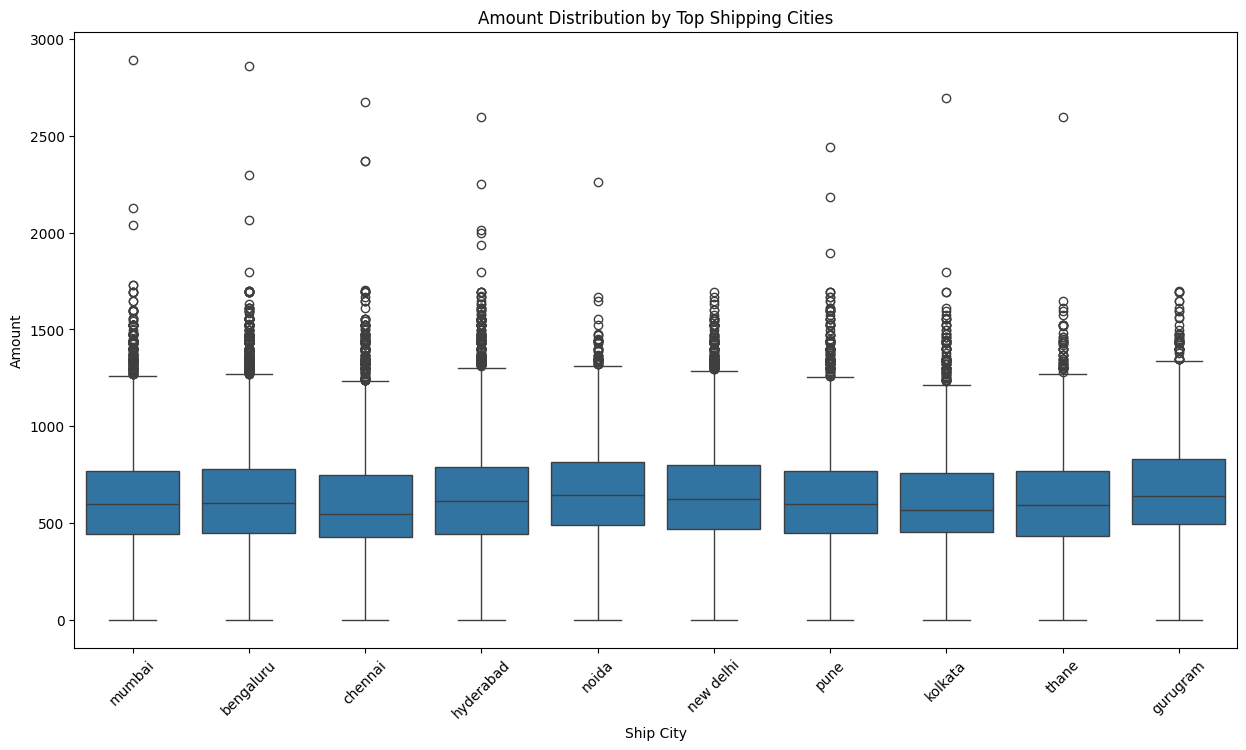

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the top cities based on frequency
top_cities = df['ship-city'].value_counts().nlargest(10).index

# Filtering the data for top cities
top_cities_data = df[df['ship-city'].isin(top_cities)]

# Plotting
plt.figure(figsize=(15, 8))
sns.boxplot(x='ship-city', y='amount', data=top_cities_data)
plt.xticks(rotation=45)
plt.title('Amount Distribution by Top Shipping Cities')
plt.xlabel('Ship City')
plt.ylabel('Amount')
plt.show()


In [23]:
# Function to remove outliers using IQR method
def remove_outliers(df, column_name):
    # Calculating Q1 and Q3
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Defining the outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering out the outliers
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return filtered_df

# Remove outliers from the entire dataset
data_cleaned = remove_outliers(df, 'amount')

# Comparing the shape of the datasets before and after outlier removal
original_shape = df.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape


((121177, 21), (117577, 21))

The original dataset contained 121,180 rows. After applying the IQR method to remove outliers from the 'amount' column, the dataset now contains 117,580 rows. This means that 3,600 rows (approximately 3% of the dataset) were identified as outliers and removed.

In [24]:
df = data_cleaned

In [25]:
# look for missing values in the ship-city column
df['ship-city'].isnull().sum()

0

##### Potential Binning of Cities with a low amount of entries in dataset
###### Maybe bin the ones with a low amount of entries so that every bin has around 1000 entries, or 2000? 4000?
###### Or find a way to sample more evenly during training. But even then the lowest occuring might be good to clump together   
###### Maybe by creating a new column, but maybe just by changing the names to '<11Entry'  to reduce features in the one hot or binary coding

In [26]:
unique_counts = df['ship-city'].value_counts()


l = 10
u = 101
o = 201


filtered_counts_1 = unique_counts[unique_counts < 2]
filtered_counts_l = unique_counts[unique_counts < l]
filtered_counts_u = unique_counts[unique_counts < u]
filtered_counts_o = unique_counts[unique_counts < o]

print(len(filtered_counts_1))
print(len(filtered_counts_l))
print(len(filtered_counts_u))
print(len(filtered_counts_o))


2121


NameError: name 'filtered_counts_l' is not defined

In [ ]:
import pandas as pd

# Assuming df['ship-city'] is your DataFrame column
unique_counts = df['ship-city'].value_counts()

# Base count: total number of entries for cities with exactly 1 occurrence
base_count = sum(df['ship-city'].isin(unique_counts.index[unique_counts == 1]))

def find_threshold(df, unique_counts, target, already_counted):
    for threshold in range(2, max(unique_counts) + 1):
        # Cities with occurrences less than or equal to the threshold
        filtered_cities = unique_counts.index[unique_counts <= threshold]

        # Exclude already counted cities
        new_cities = set(filtered_cities) - set(already_counted)

        # Filter the original DataFrame for these new cities and count the rows
        total_entries = len(df[df['ship-city'].isin(new_cities)])

        # Check if total entries meet or exceed the target
        if total_entries >= target:
            return threshold, total_entries, filtered_cities

    return None, None, already_counted

# Number of iterations to find thresholds for the same target count
num_iterations = 3  # You can adjust this value as needed

# Using the same target count for each iteration
current_target = base_count

# Keep track of already counted cities
already_counted_cities = set()

for i in range(num_iterations):
    # Find the threshold for the current target
    threshold, entries_at_threshold, counted_cities = find_threshold(df, unique_counts, current_target, already_counted_cities)

    # Update the set of already counted cities
    already_counted_cities.update(counted_cities)

    # Print the results for this iteration
    print(f"Iteration {i + 1}:")
    print(f"  Threshold: {threshold}")
    print(f"  Total new entries at this threshold: {entries_at_threshold}\n")


Iteration 1:
  Threshold: 2
  Total new entries at this threshold: 4259

Iteration 2:
  Threshold: 4
  Total new entries at this threshold: 2923

Iteration 3:
  Threshold: 6
  Total new entries at this threshold: 2306



In [27]:
import pandas as pd

# Assuming df['ship-city'] is your DataFrame column
unique_counts = df['ship-city'].value_counts()

# Maximum threshold to consider
max_threshold = 10  # You can adjust this value as needed

threshold_counts = {}

for threshold in range(1, max_threshold + 1):
    # Cities with occurrences less than or equal to the threshold
    filtered_cities = unique_counts[unique_counts <= threshold]

    # Count of these cities
    count_at_threshold = len(filtered_cities)

    # Store the count at this threshold
    threshold_counts[threshold] = count_at_threshold

    # Print the result
    print(f"Threshold {threshold}: {count_at_threshold} cities")

# threshold_counts now contains the counts for each threshold



Threshold 1: 2121 cities
Threshold 2: 3172 cities
Threshold 3: 3728 cities
Threshold 4: 4044 cities
Threshold 5: 4288 cities
Threshold 6: 4469 cities
Threshold 7: 4605 cities
Threshold 8: 4729 cities
Threshold 9: 4810 cities
Threshold 10: 4886 cities


##### This code might work for finding bins of X size in the Y way I want

In [30]:
import pandas as pd

def find_thresholds(df, column_name, target_entries, num_rounds):
    current_max_occurrences = 1

    for round in range(1, num_rounds + 1):
        total_entries = 0
        while total_entries < target_entries:
            # Filter values with occurrences less than or equal to current_max_occurrences
            value_counts = df[column_name].value_counts()
            filtered_counts = value_counts[value_counts <= current_max_occurrences]

            # Calculate the total number of entries for these filtered values
            total_entries = sum(filtered_counts)

            if total_entries < target_entries:
                current_max_occurrences += 1

        # Print the result for this round
        print(f"Iteration {round}:")
        print(f"  Y (Max Frequency): {current_max_occurrences}")
        print(f"  Sum of Counts for Values: {total_entries}\n")

        # Increment Y for the next iteration
        current_max_occurrences += 1

# Example usage
X = 6000  # Set your target entries
num_rounds = 6  # Set the number of iterations
find_thresholds(df, 'ship-city', X, num_rounds)


Iteration 1:
  Y (Max Frequency): 4
  Sum of Counts for Values: 7155

Iteration 2:
  Y (Max Frequency): 5
  Sum of Counts for Values: 8375

Iteration 3:
  Y (Max Frequency): 6
  Sum of Counts for Values: 9461

Iteration 4:
  Y (Max Frequency): 7
  Sum of Counts for Values: 10413

Iteration 5:
  Y (Max Frequency): 8
  Sum of Counts for Values: 11405

Iteration 6:
  Y (Max Frequency): 9
  Sum of Counts for Values: 12134



In [ ]:
#Check if it actually does 
unique_counts = df['ship-city'].value_counts()


l = 10
u = 101
o = 201


filtered_counts_1 = unique_counts[unique_counts < 1 && unique_counts > 3
filtered_counts_l = unique_counts[unique_counts < l]
filtered_counts_u = unique_counts[unique_counts < u]
filtered_counts_o = unique_counts[unique_counts < o]

print(len(filtered_counts_1))
print(len(filtered_counts_l))
print(len(filtered_counts_u))
print(len(filtered_counts_o))

In [50]:
import pandas as pd

# Assuming your DataFrame is named 'df' and you want to count unique values in the 'column_name' column.
# Replace 'column_name' with the actual name of the column you're interested in.

# Calculate unique value counts
unique_counts = df['ship-city'].value_counts()

# Filter the counts for values with 100 to 200 entries
filtered_counts = unique_counts[(unique_counts >= 100) & (unique_counts <= 200)]

# Calculate the total amount of entries for the filtered values
total_entries = filtered_counts.sum()

print(f'Total entries for values with 100 to 200 entries per value: {total_entries}')


Total entries for values with 100 to 200 entries per value: 7109


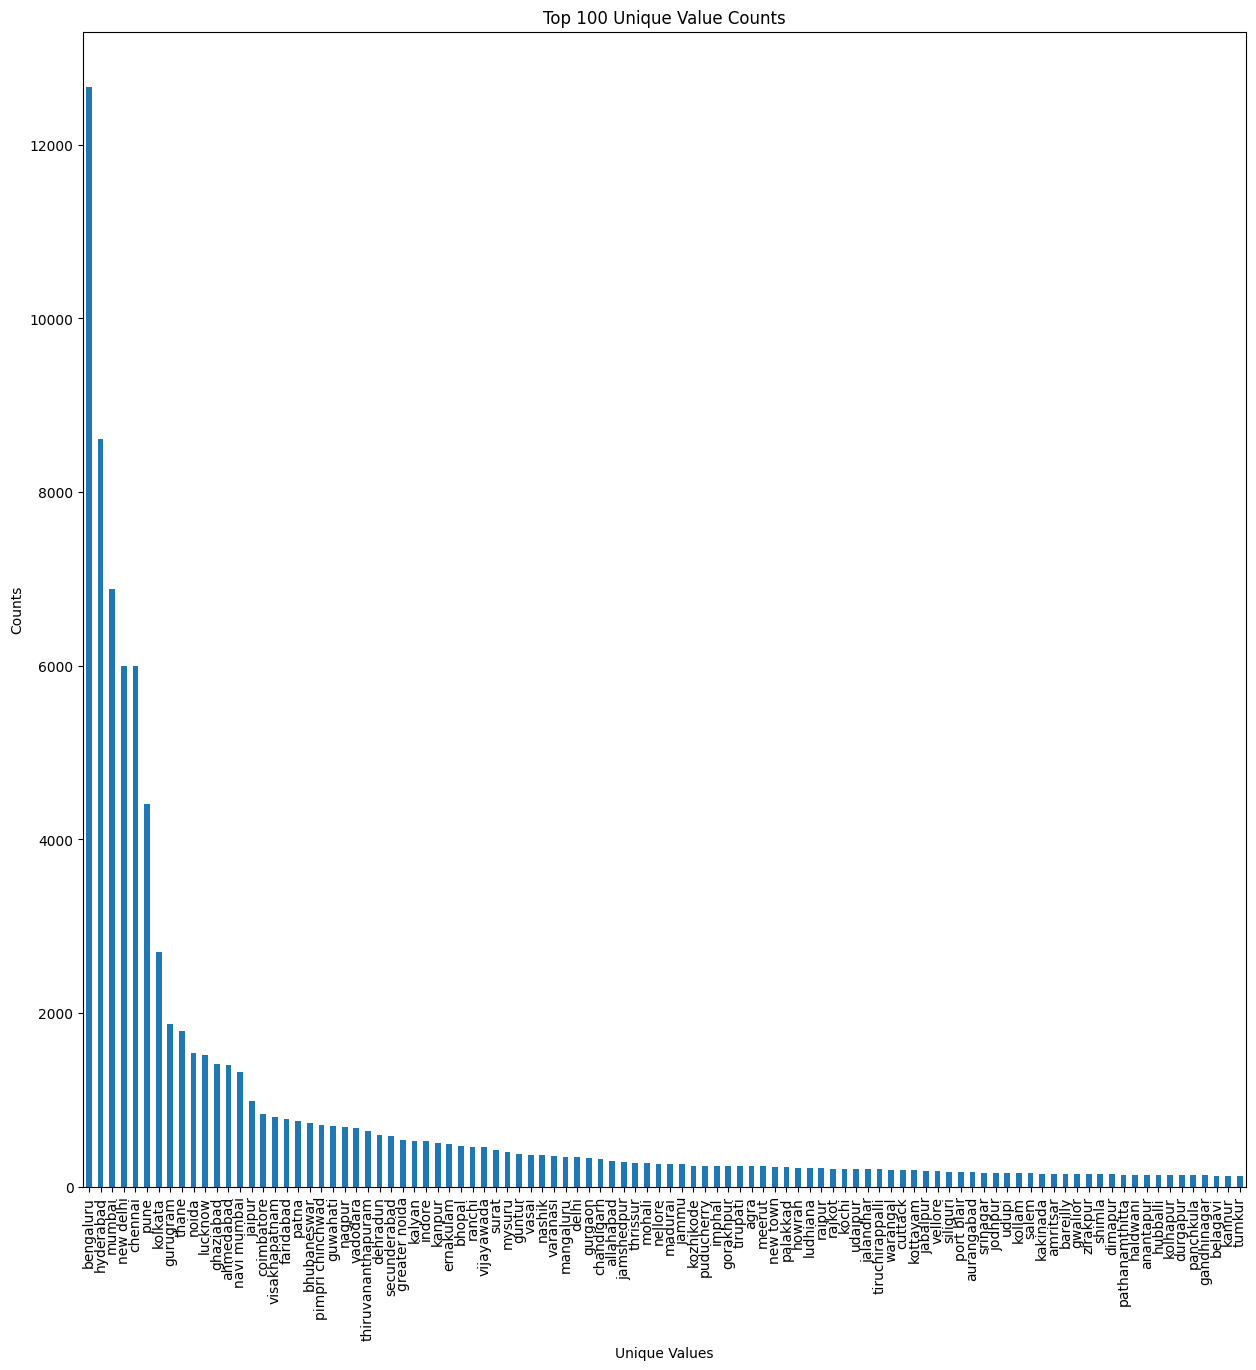

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and you want to count unique values in the 'column_name' column.
# Replace 'column_name' with the actual name of the column you're interested in.

unique_counts = df['ship-city'].value_counts().head(100)


# Create a bar plot
plt.figure(figsize=(15, 15))  # Set the figure size
unique_counts.plot(kind='bar')
plt.title('Top 100 Unique Value Counts')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()  # Show the plot


In [ ]:
# Try to fuzzy match unique values with only one entry in 'ship-city'


In [ ]:

# Assuming you have a DataFrame called 'df' and you want to save the 'column_name' column
#column_name = 'ship-city'  # Replace with the actual column name

# Create a new DataFrame containing only the desired column
#selected_column = df[[column_name]]

# Save the selected column to a CSV file
#selected_column.to_csv('ship-city.csv', index=False)



In [25]:
#df.to_csv('AmazonDataSales_v2.csv', index=False)

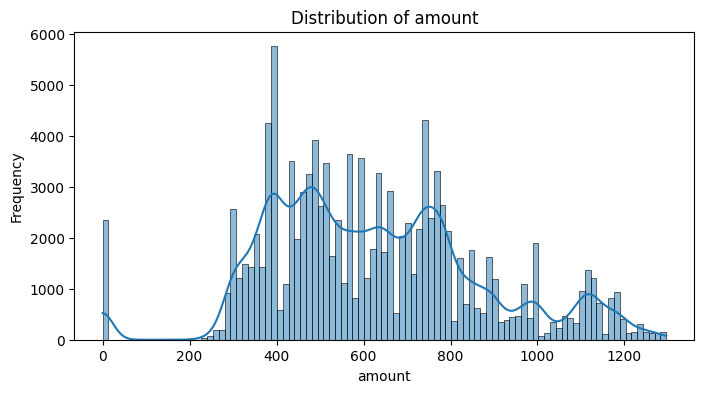

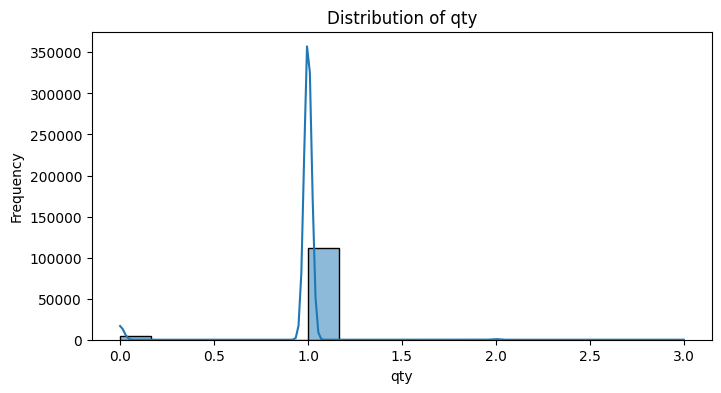

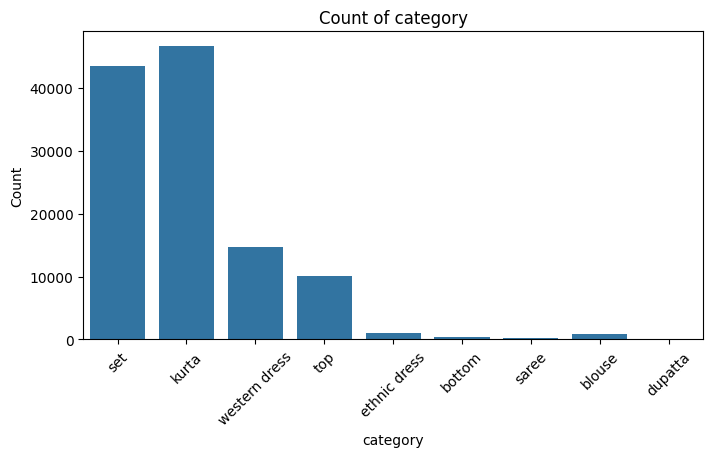

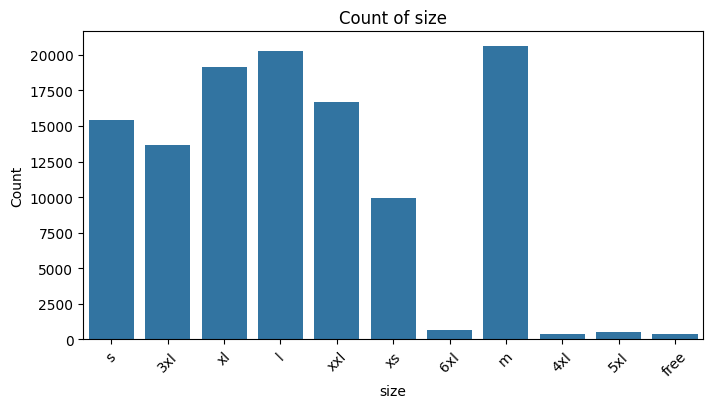

In [26]:
#Vizualize distribution in df columns: 'amount', 'qty', 'category', 'size'


# Assuming 'df' is your DataFrame

# Visualize distributions of numeric columns: 'amount' and 'qty'
for column in ['amount', 'qty']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# For categorical columns like 'category' and 'size', use count plots
for column in ['category', 'size']:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[column])
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate labels for better readability if necessary
    plt.show()



Maybe dropping the one-hot columns XS, 6xl, 4xl, 5xl, free, ethnic dress, bottom, aree, blouse, dupatta, all qty except 1 would help the model?   
(while still keeping in scope only using the columns we're supposed too)   

##### End of dataprocessing  
I stopped before reaching the end of all the possibilities because the focus for the assignment was not the quality of the result but the analysis of the models result
